## **Никонов Максим 416 группа**  

*Московский государственный университет имени М.В. Ломоносова, город Москва*

***Источник: [Practical implementation of extended Kalman filtering in chemical systems with sparse measurements](https://vk.com/doc148888053_622147529?hash=507a743ed519be4116&dl=f54448a5e94ac4163c)***

*[4] Модель на стр. 46 – 51. Моделировать решение СДУ с шагом 0.001, наблюдения с шагом 1.*

## Содержание:
* **[1. Непрерывная стохастическая система наблюдений](#1)**
* **[2. Генерация и визуализация](#2)**
* [2.1. Моделирование компонент](#2_1)
* [2.2. Моделирование наблюдений](#2_2)
* [2.3. Траектории мат. ожидания компонент](#2_3)
* [2.4.Среднеквадратическое отклонение значения](#2_4)
* **[3. The Unscented Kalman Filter](#3)**
* [3.1. Среднеквадратическое отклонение для UKF на пучке из *10 000* траекторий](#3_1)
* [3.2. Об оценке фильтрации](#3_2)
* [3.3. Некоторые цитаты про UKF фильтр](#3_3)
* **[4. The Bootstrap Particle Filter](#4)**
* [4.1. Среднеквадратическое отклонение для BPF на пучке из *10 000* траекторий](#4_1)
* [4.2. Об оценке фильтрации](#4_2)
* [4.3. Бонус: Extensible Tensorflow library for differentiable particle filtering](#4_3)
* **[5. Все на одном графике](#5)**
* [5.1. Фильтры UKF и BPF на одном графике (задание 3)](#5_1)
* [5.2. СКО значения и СКО ошибок UKF и BPF на одном графике для пучка из *10 000* траекторий (задание 4)](#5_2)
* **[6. Список литературы](#6)**

________________

#### **Непрерывно-дискретная стохастическая система наблюдений и другие сопутствующие условия:** 
<a class="anchor" id="1"></a>

$$
\large dx(t) = a(x(t))dt + b(t)dw(t), \space
\large x = (x_1, x_2, x_3)^T,\space
\large w(t) \sim \mathcal{N}(0, Q) \\ 
\large Y_n = A_t(x(t_n)) + B_{t_n} \cdot W_{t_n}, \space n \in \mathbb{N}\\
$$

$$
\large v=\begin{bmatrix}
\ -1& 1& 1\\
\ 0& -2& 1
\end{bmatrix},\space 
\large r=\begin{bmatrix}
\ k_1c_A-k_2c_Bc_C\\
\ k_3c^2_B-k_4c_C
\end{bmatrix} = \large \begin{bmatrix}
k_1x_0(t) - k_2x_1(t)x_2(t) \\[0.5em]
k_3x^2_1(t)- k_4x_2 \\
\end{bmatrix}\\
\large Q=
\begin{bmatrix}
10^{-6}/\sigma\\
&\!\!10^{-6}/\sigma\\
&&10^{-6}/\sigma
\end{bmatrix} \stackrel{\sigma=h}{=} \begin{bmatrix}
10^{-6}/h\\
&\!\!10^{-6}/h\\
&&10^{-6}/h
\end{bmatrix}, \space h = 0.001, \space
\large G=
\begin{bmatrix}
1\\
&\!\!1\\
&&1
\end{bmatrix} \\
\large X_0=[0.5,0.05,0]^T, \space X(0) = X_0, \space \mathbb{E}(X_0) = m_0, \space cov(X_0,X_0) = Q_0\\
\large RT = 32.84, \space k_1=0.5, \space k_2 = 0.05, \space k_3 = 0.2, \space k_4 = 0.01 \\
$$

$$
\LARGE a_x(X(S),S)=v^Tr, \space \space b(t) = G\sqrt{Q} \\
\LARGE X_t=X_{t-1}+v^Trh+G\sqrt{Q}\sqrt{h}\cdot N(0,1) \\
\LARGE Y_t = [RT \space RT \space RT]X_t+ 0.25\cdot N(0,1) \\
$$

__________________________

# **Генерация и визуализация** 
<a class="anchor" id="2"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 30, 8
from numpy.random import randn
from tqdm import tqdm

In [2]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

In [3]:
h = 0.001

In [4]:
RT = 32.84
v = np.array([[-1, 1, 1],
              [0, -2, 1]])
k1 = 0.5
k2 = 0.05
k3 = 0.2
k4 = 0.01
N = 5000

X0 = np.array([[0.5],[0.05],[0]])
dim_X = 3
dim_Y = 1
X = np.zeros((dim_X, N), dtype=float)
X = np.concatenate((X0, X), axis=1)
Y = np.zeros(N + dim_Y, dtype=float)
G = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])
Q  = np.array([[10**(-6)/h, 0, 0],
               [0, 10**(-6)/h, 0],
               [0, 0, 10**(-6)/h]])

X_noise = np.random.normal(loc=0, scale=1, size=(3, N + 1))

In [5]:
def r(x):
    return np.array([k1*x[0]-k2*x[1]*x[2],k3*x[1]*x[1]-k4*x[2]])
def F(x,h):
    return x + np.dot(v.T, r(x)) * h
def H(x):
    return [np.dot([RT, RT, RT], x).tolist()]

def Noise(G, Q, h, X_noise):
    return np.dot(np.dot(G, np.sqrt(Q))*np.sqrt(h), X_noise) 

### ***Компоненты***
<a class="anchor" id="2_1"></a>

100%|██████████| 5000/5000 [00:00<00:00, 39098.54it/s]


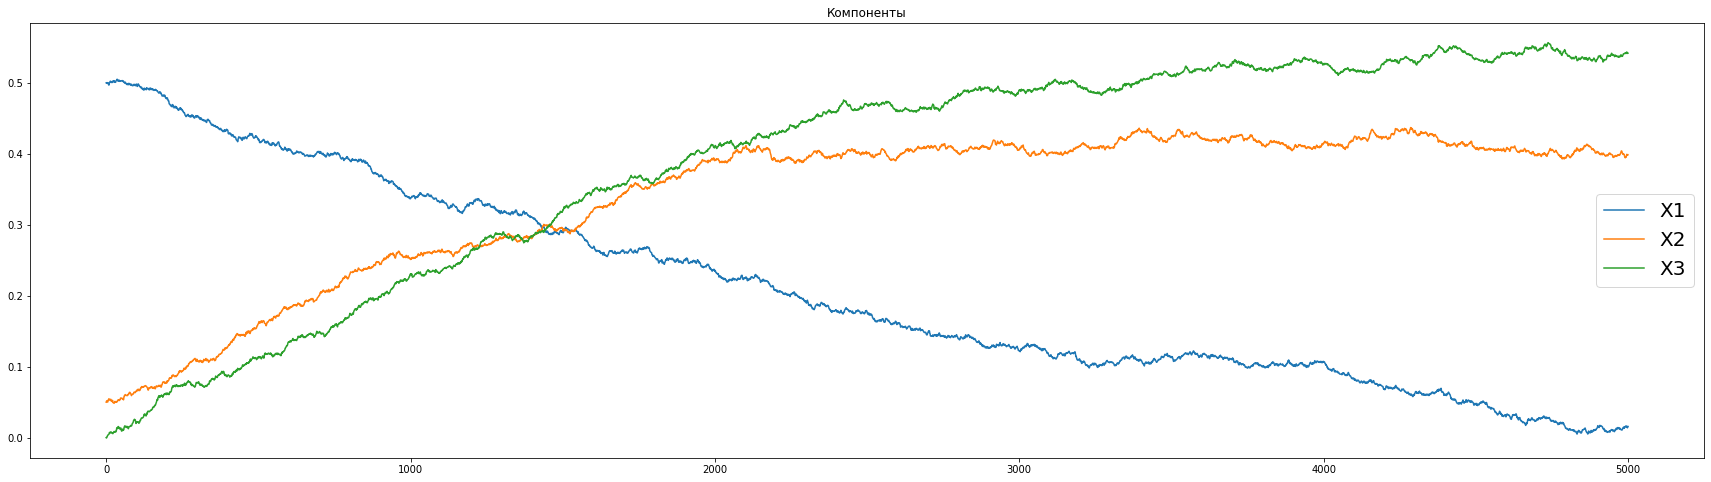

In [6]:
for i in tqdm((range(1,N+1))):
    X[:,i] = F(X[:,i-1], h) + Noise(G,Q,h,X_noise[:,i-1])
plt.plot(X[0,:],label='X1');
plt.plot(X[1,:],label='X2');
plt.plot(X[2,:],label='X3');
plt.title('Компоненты')
plt.legend(fontsize=20)

***Шаг равен 0.001, ниже наглядно***

Text(0.5, 1.0, 'Компоненты, шаг = 0.001')

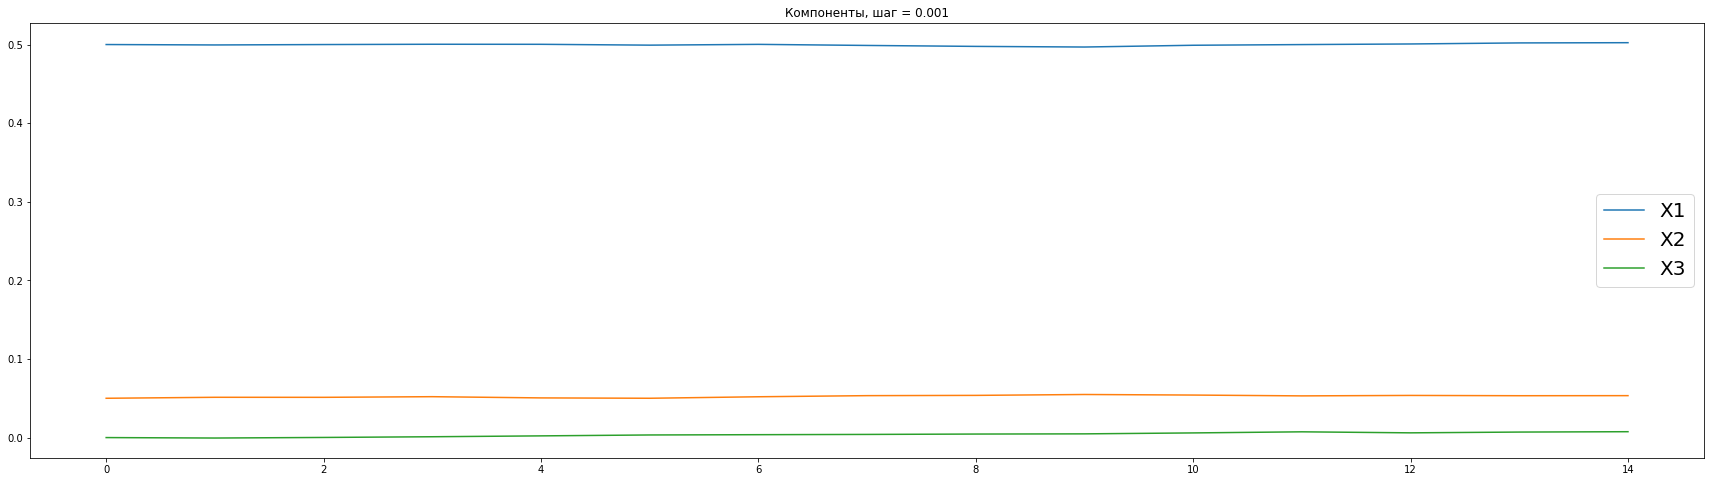

In [7]:
plt.plot(X[0,:15],label='X1');
plt.plot(X[1,:15],label='X2');
plt.plot(X[2,:15],label='X3');
plt.legend(fontsize=20)
plt.title('Компоненты, шаг = 0.001')

### ***Наблюдения***
<a class="anchor" id="2_2"></a>

In [8]:
zs =[]
for i in tqdm(range(N)):
    Y[i] = 0.25*np.random.normal(loc=0,scale=1,size=(1,)) + H(X[:,i])
    zs.append(Y[i])

100%|██████████| 5000/5000 [00:00<00:00, 52220.96it/s]


Text(0.5, 1.0, 'Наблюдения, шаг = 1')

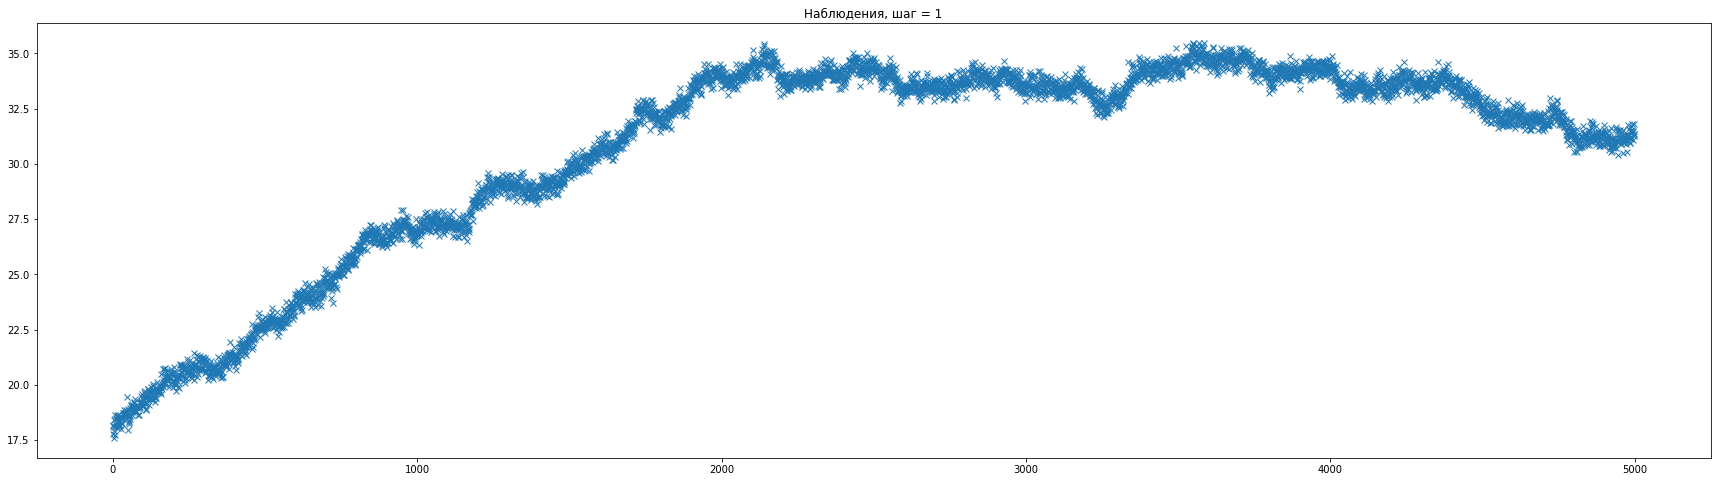

In [9]:
plt.plot(zs, marker='x',ls='');
plt.title('Наблюдения, шаг = 1')

***Шаг равен 1, ниже наглядно***

Text(0.5, 1.0, 'Наблюдения, шаг = 1')

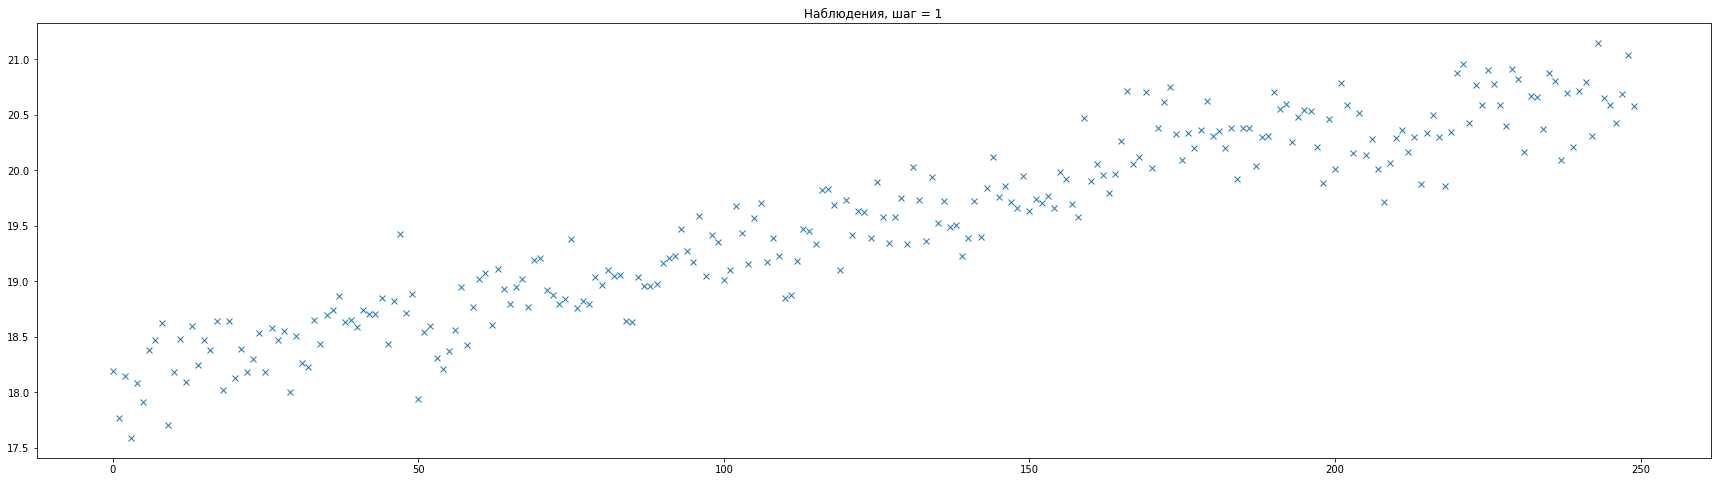

In [10]:
plt.plot(zs[0:250], marker='x',ls='');
plt.title('Наблюдения, шаг = 1')

Text(0.5, 1.0, 'Наблюдения, шаг = 1')

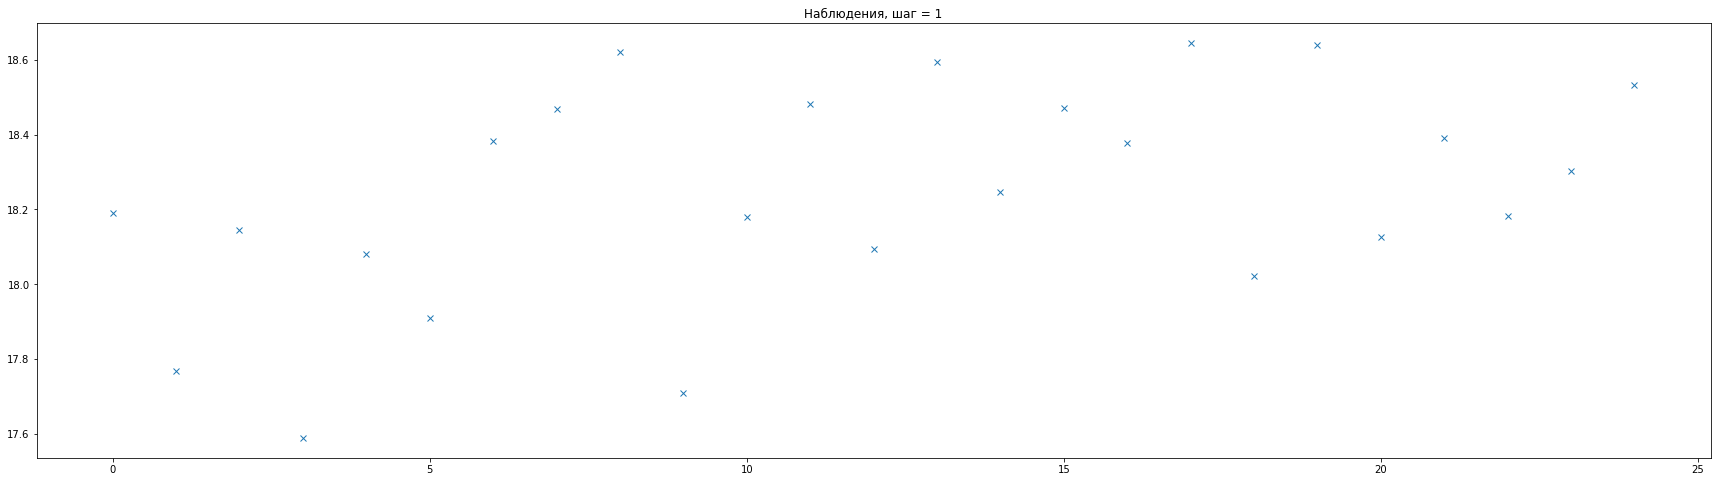

In [11]:
plt.plot(zs[0:25], marker='x',ls='');
plt.title('Наблюдения, шаг = 1')

In [154]:
N_avg = 10_000
X_avg = []
X_avg_sqr = []
for _ in tqdm(range(N_avg)):
    X_tmp = np.zeros((dim_X, N-1), dtype=float)
    X_tmp = np.concatenate((X0, X_tmp), axis=1)
    X_nnoise = np.random.normal(loc=0, scale=1, size=(3, N+1))
    for i in range(1,N):
        X_tmp[:,i] = F(X_tmp[:,i-1], h) + Noise(G,Q,h,X_nnoise[:,i-1])
    X_avg.append(X_tmp)

100%|██████████| 10000/10000 [14:13<00:00, 11.72it/s]


In [155]:
X_avg = np.array(X_avg)
X_avg_mean = np.mean(X_avg, axis=0)

### ***Траектории мат. ожидания компонент***
<a class="anchor" id="2_3"></a>

Text(0.5, 1.0, 'MEAN X3')

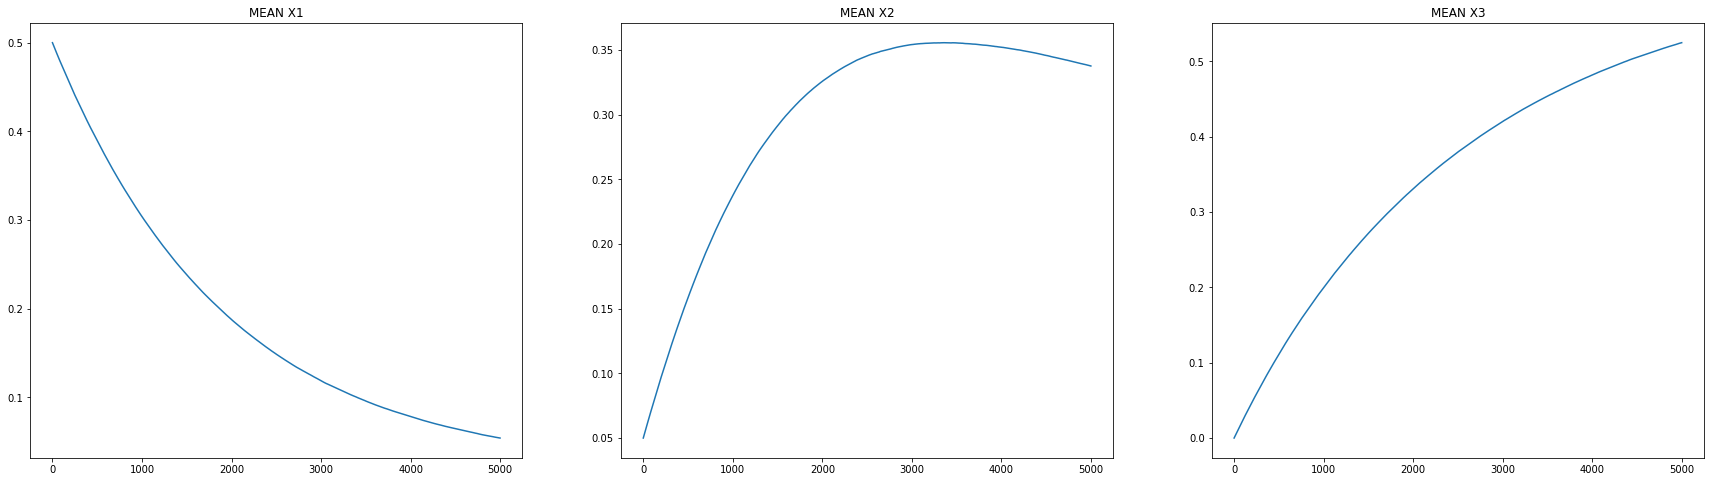

In [156]:
import pylab

pylab.subplot (1, 3, 1)
plt.plot(X_avg_mean[0,:],label='X1');
plt.title('MEAN X1')

pylab.subplot (1, 3, 2)
plt.plot(X_avg_mean[1,:],label='X2');
plt.title('MEAN X2')

pylab.subplot (1, 3, 3)
plt.plot(X_avg_mean[2,:],label='X3');
plt.title('MEAN X3')

### ***СКО значения***
<a class="anchor" id="2_4"></a>

In [157]:
std_x = np.std(X_avg, axis=0)

Text(0.5, 1.0, 'STD ERR X3')

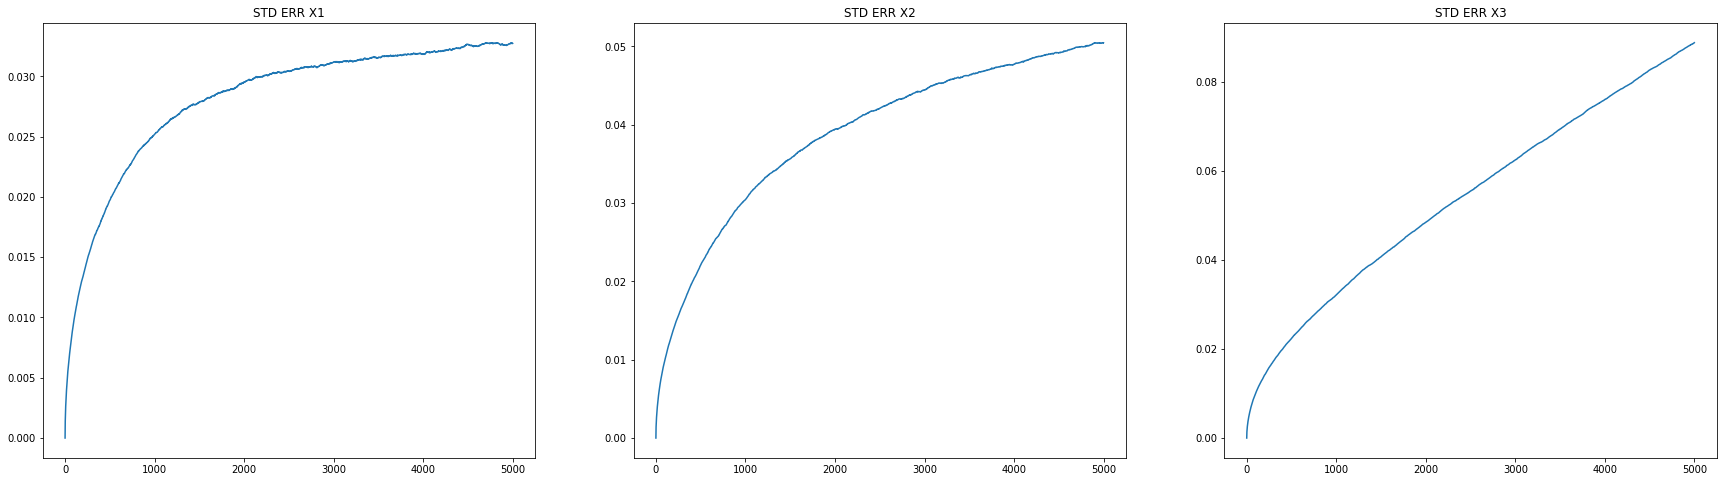

In [158]:
pylab.subplot (1, 3, 1)
plt.plot(std_x[0,:])
plt.title('STD ERR X1')

pylab.subplot (1, 3, 2)
plt.plot(std_x[1,:])
plt.title('STD ERR X2')

pylab.subplot (1, 3, 3)
plt.plot(std_x[2,:])
plt.title('STD ERR X3')

***Начало в нуле обсуловлено наличием начального условия***

_______________

# **The Unscented Kalman Filter**
<a class="anchor" id="3"></a>

In [17]:
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=3, kappa=100)
#sigmas = MerweScaledSigmaPoints(3, alpha=0.0000011, beta=1.5432, kappa=-1.3)
ukf = UnscentedKalmanFilter(dim_x=3, dim_z=1, dt=h, hx=H, fx=F, points=sigmas)
ukf.P *= 0.001
ukf.R *= 0.001
ukf.x = X0.reshape(3)
ukf.Q = Q_discrete_white_noise(3, dt=2, var=0.00001)

xs1, xs2, xs3 = [], [], []

for i in tqdm(range(N)):
    ukf.predict()
    ukf.update(Y[i])
    xs1.append(ukf.x[0])
    xs2.append(ukf.x[1])
    xs3.append(ukf.x[2])

100%|██████████| 5000/5000 [00:01<00:00, 3262.36it/s]


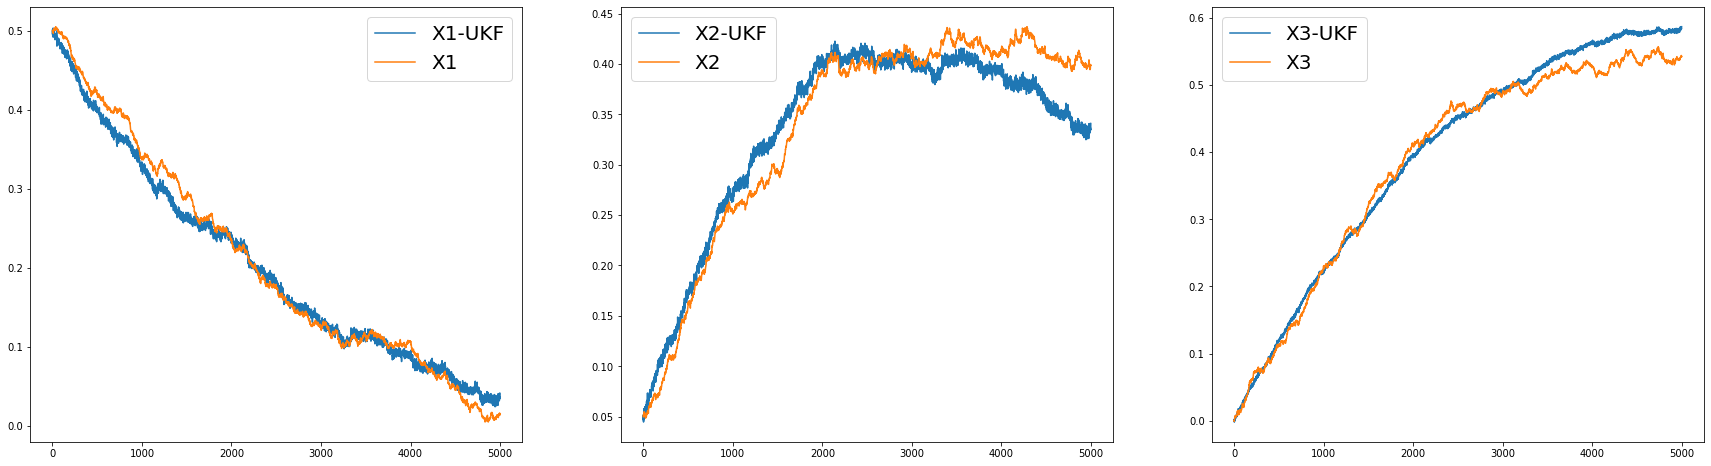

In [18]:
pylab.subplot (1, 3, 1)
plt.plot(xs1,label='X1-UKF');
plt.plot(X[0,:],label='X1');
plt.legend(fontsize=20)

pylab.subplot (1, 3, 2)
plt.plot(xs2,label='X2-UKF');
plt.plot(X[1,:],label='X2');
plt.legend(fontsize=20)

pylab.subplot (1, 3, 3)
plt.plot(xs3,label='X3-UKF');
plt.plot(X[2,:],label='X3');
plt.legend(fontsize=20)

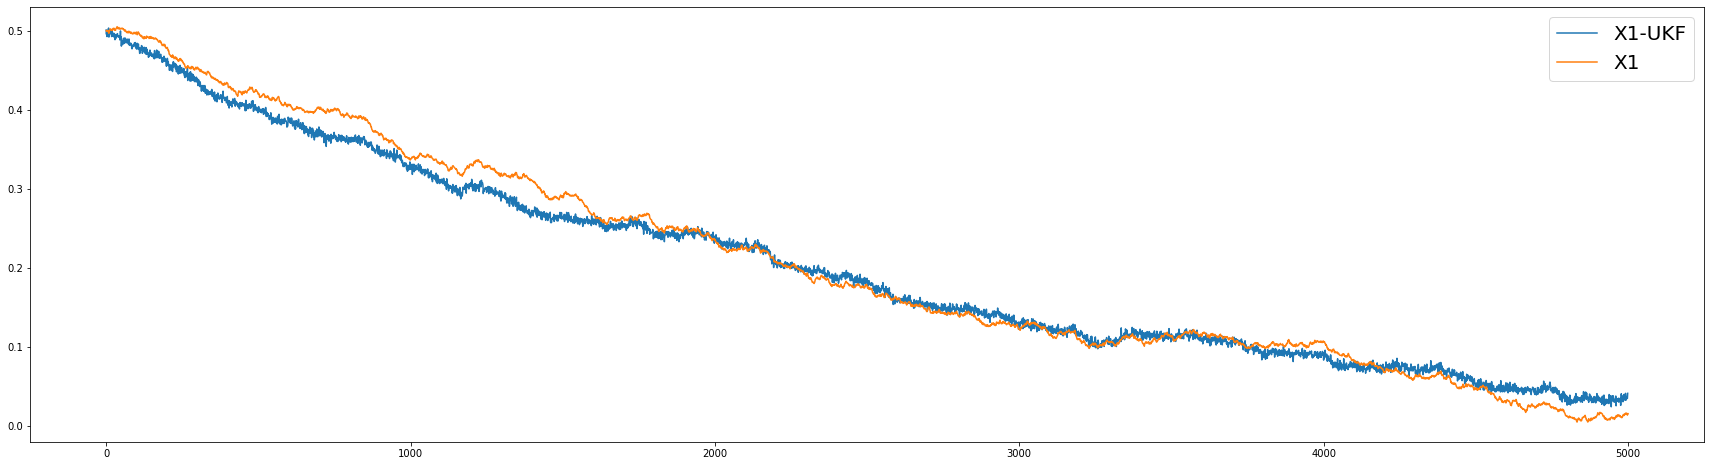

In [19]:
plt.plot(xs1,label='X1-UKF');
plt.plot(X[0,:],label='X1');
#plt.plot(zs, marker='x', ls='',label='view');
plt.legend(fontsize=20)

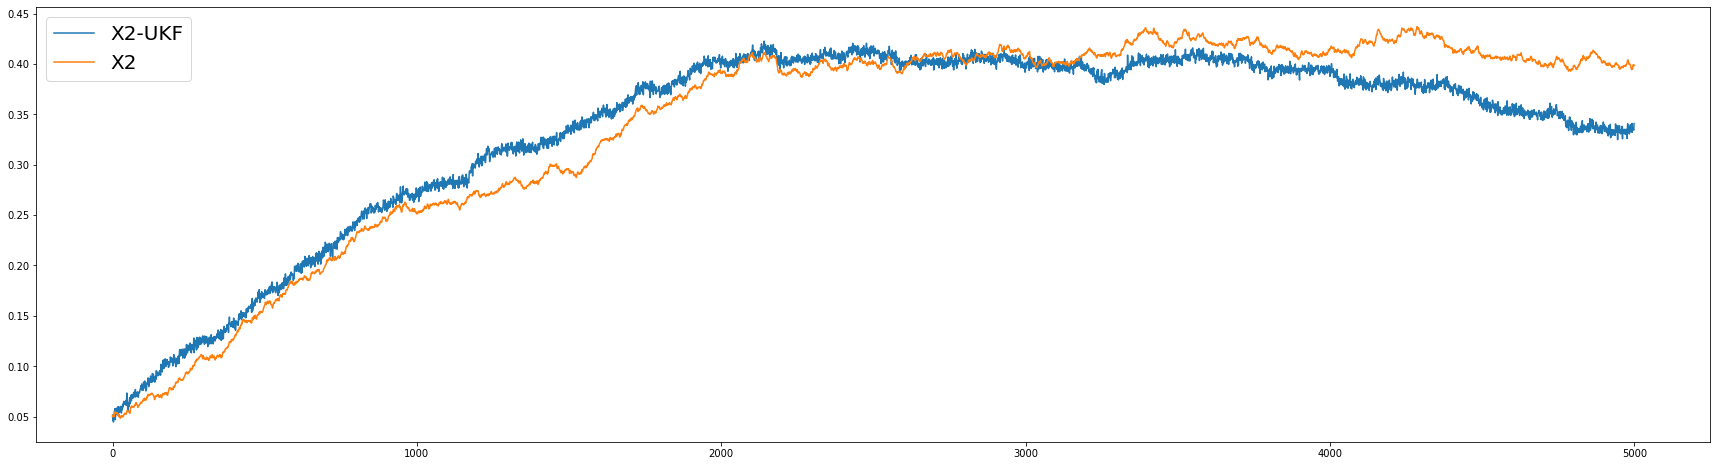

In [20]:
plt.plot(xs2,label='X2-UKF');
plt.plot(X[1,:],label='X2');
#plt.plot(zs, marker='x', ls='',label='view');
plt.legend(fontsize=20)

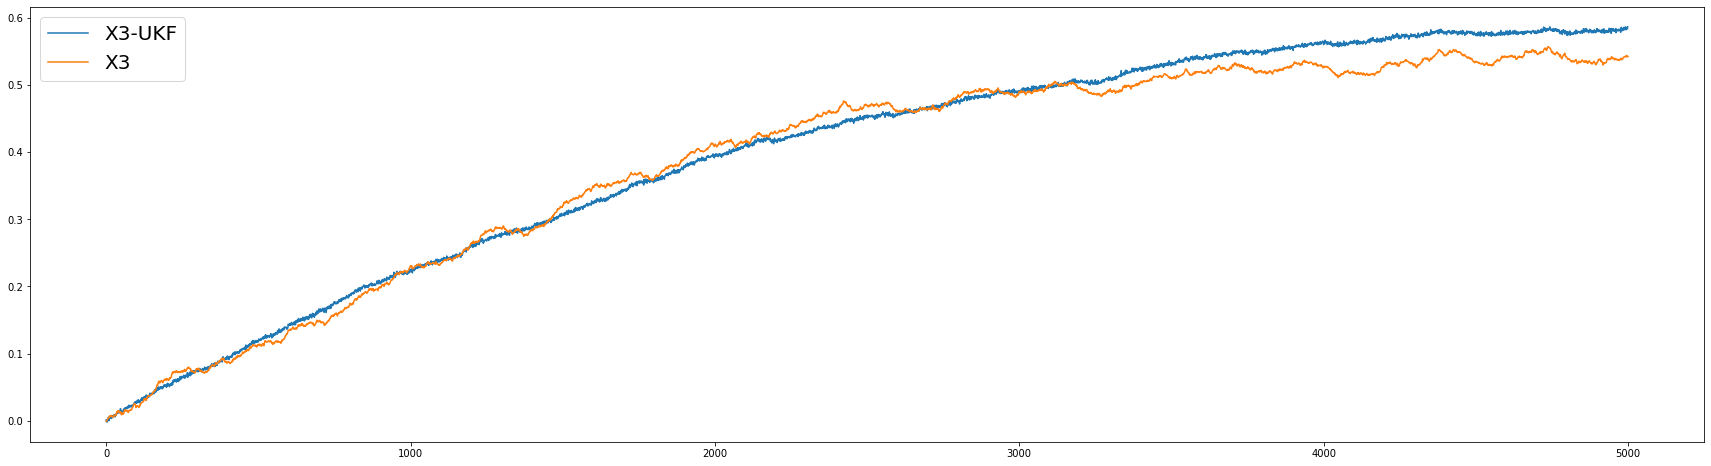

In [21]:
plt.plot(xs3,label='X3-UKF');
plt.plot(X[2,:],label='X3');
#plt.plot(zs, marker='x', ls='',label='view');
plt.legend(fontsize=20)

In [159]:
UKF_avg = []
for _ in tqdm(range(N_avg)):
    sigmas_tmp = JulierSigmaPoints(n=3, kappa=100)
    ukf_tmp = UnscentedKalmanFilter(dim_x=3, dim_z=1, dt=h, hx=H, fx=F, points=sigmas_tmp)
    ukf_tmp.P *= 0.001
    ukf_tmp.R *= 0.001
    X0 = np.array([[0.5],[0.05],[0]])
    ukf_tmp.x = X0.reshape(3)
    ukf_tmp.Q = Q_discrete_white_noise(3, dt=2, var=0.00001)
    Y_tmp = np.zeros(N + dim_Y, dtype=float)
    xs1_tmp, xs2_tmp, xs3_tmp = [], [], []
    UKF_tmp = []
    for i in range(0,N):
        Y_tmp[i] = 0.25*np.random.normal(loc=0,scale=1,size=(1,)) + H(X_avg[_,:,i])
    for i in range(0,N):
        ukf_tmp.predict()
        ukf_tmp.update(Y_tmp[i])
        xs1_tmp.append(ukf_tmp.x[0])
        xs2_tmp.append(ukf_tmp.x[1])
        xs3_tmp.append(ukf_tmp.x[2])    
    xs1_tmp = np.array(xs1_tmp)
    xs2_tmp = np.array(xs2_tmp)
    xs3_tmp = np.array(xs3_tmp)
    UKF_tmp.append(xs1_tmp)
    UKF_tmp.append(xs2_tmp)
    UKF_tmp.append(xs3_tmp)
    UKF_avg.append(UKF_tmp)

100%|██████████| 10000/10000 [3:52:54<00:00,  1.40s/it] 


In [160]:
UKF_avg = np.array(UKF_avg)

In [161]:
UKF_std = np.std(X_avg - UKF_avg, axis=0)

### ***СКО ошибки для UKF***
<a class="anchor" id="3_1"></a>

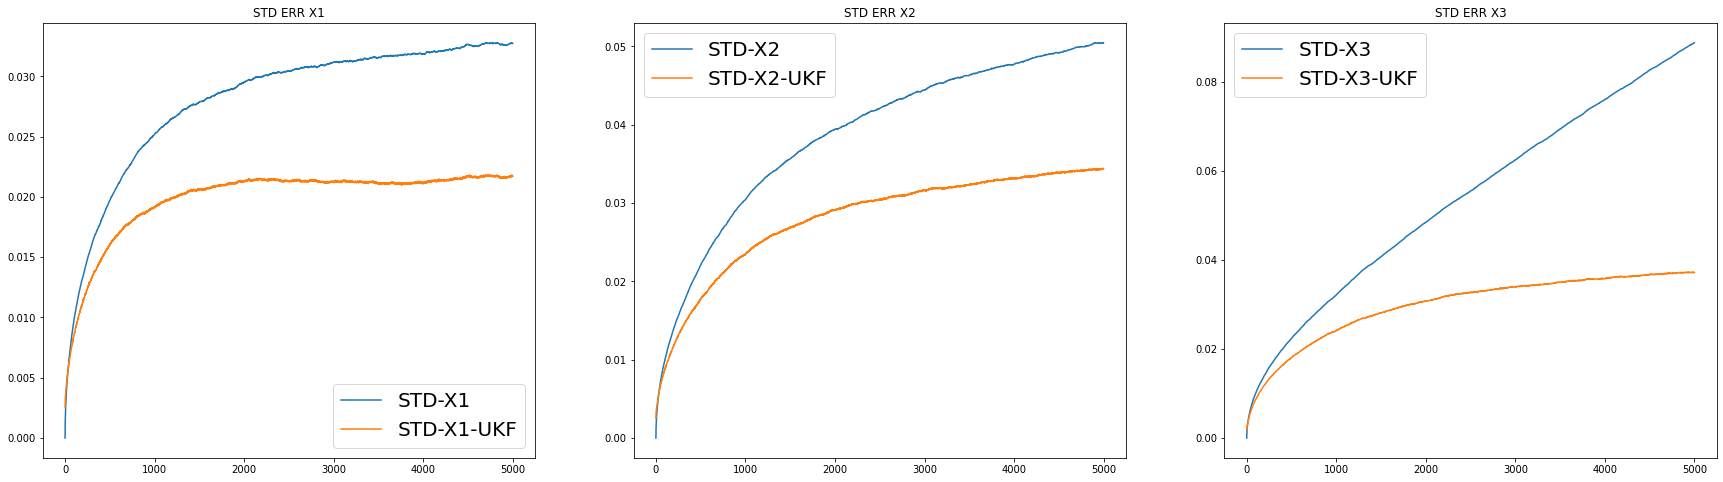

In [162]:
pylab.subplot (1, 3, 1)
plt.plot(std_x[0,:], label='STD-X1')
plt.plot(UKF_std[0,:], label='STD-X1-UKF')
plt.title('STD ERR X1')
plt.legend(fontsize=20)

pylab.subplot (1, 3, 2)
plt.plot(std_x[1,:],label='STD-X2')
plt.plot(UKF_std[1,:],label='STD-X2-UKF')
plt.title('STD ERR X2')
plt.legend(fontsize=20)

pylab.subplot (1, 3, 3)
plt.plot(std_x[2,:],label='STD-X3')
plt.plot(UKF_std[2,:],label='STD-X3-UKF')
plt.title('STD ERR X3')
plt.legend(fontsize=20)

0.008210313257591039


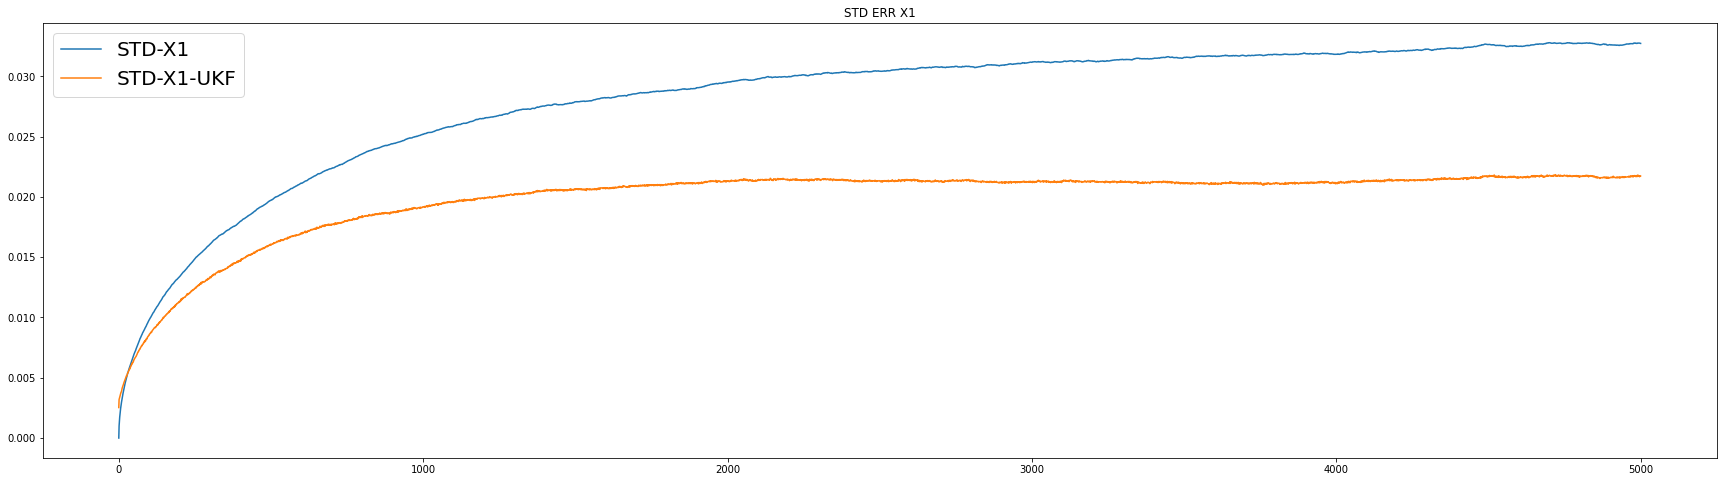

In [163]:
print(np.mean(std_x[0,:]-UKF_std[0,:]))
plt.plot(std_x[0,:], label='STD-X1')
plt.plot(UKF_std[0,:], label='STD-X1-UKF')
plt.title('STD ERR X1')
plt.legend(fontsize=20)

0.010744909933976289


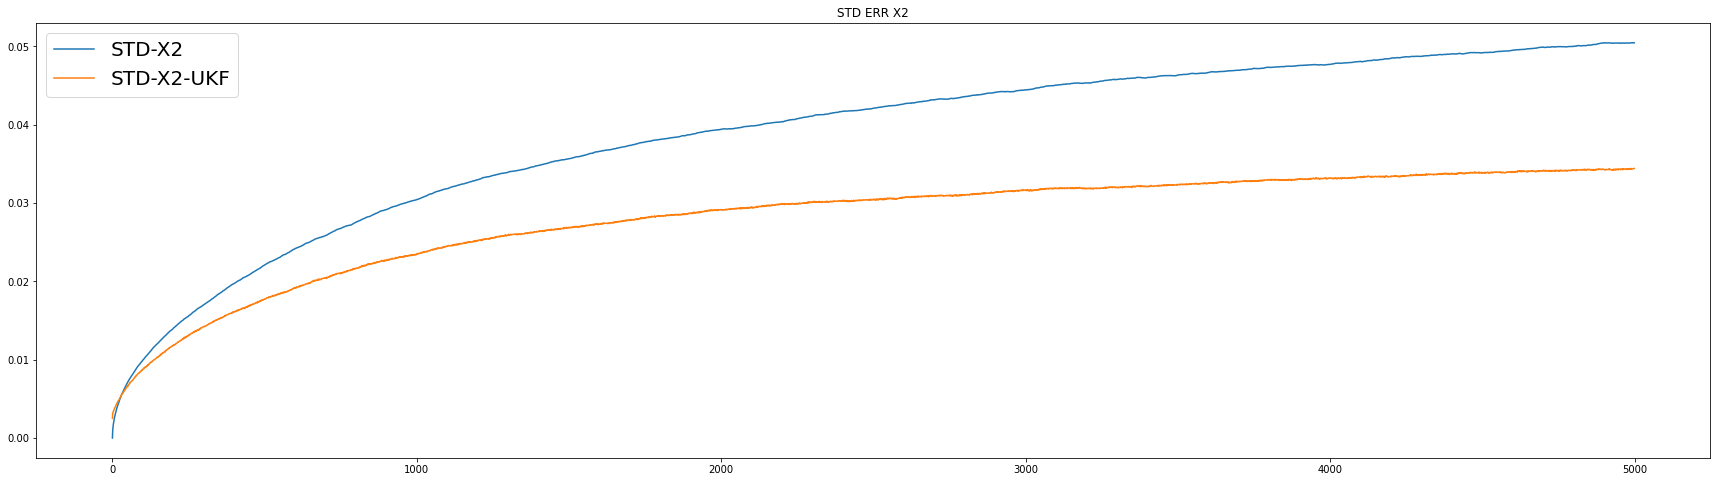

In [164]:
print(np.mean(std_x[1,:]-UKF_std[1,:]))
plt.plot(std_x[1,:],label='STD-X2')
plt.plot(UKF_std[1,:],label='STD-X2-UKF')
plt.title('STD ERR X2')
plt.legend(fontsize=20)

0.024041763827345287


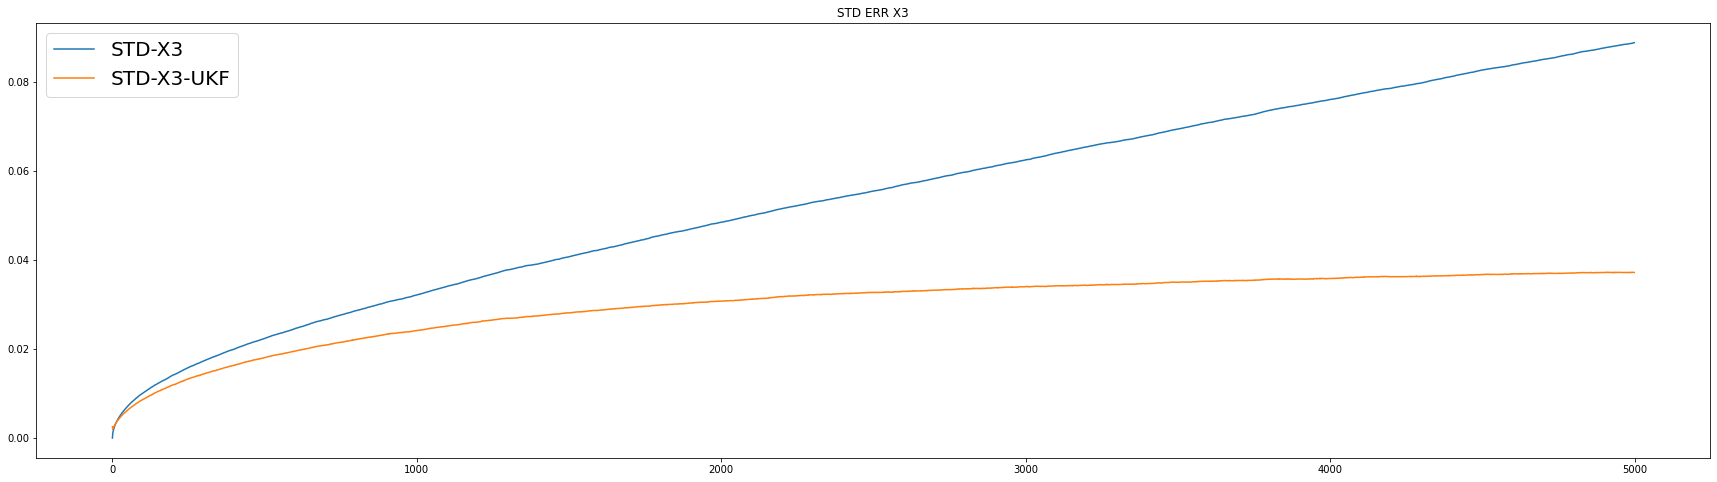

In [165]:
print(np.mean(std_x[2,:]-UKF_std[2,:]))
plt.plot(std_x[2,:],label='STD-X3')
plt.plot(UKF_std[2,:],label='STD-X3-UKF')
plt.title('STD ERR X3')
plt.legend(fontsize=20)

### ***Об оценке фильтрации***
<a class="anchor" id="3_2"></a>

Возьмем средние от СКО значения - СКО ошибки для UKF для каждой компоненты

$
\large mean(std_{i}(X)-std_{i}(UKF)), \space i = 0,1,2
$

In [166]:
print(np.mean(std_x[0,:]-UKF_std[0,:]))
print(np.mean(std_x[1,:]-UKF_std[1,:]))
print(np.mean(std_x[2,:]-UKF_std[2,:]))

0.008210313257591039
0.010744909933976289
0.024041763827345287


Для каждой траектории оценка UKF лучше тривиальной оценки, хоть это и сразу очевидно из графиков

### ***Некоторые цитаты про UKF фильтр***
<a class="anchor" id="3_3"></a>

К недостаткам предложенного алгоритма (9.10) – (9.16) можно отнести его необоснованность, неоптимальность и незамкнутость

(или бесконечную размерность): алгоритм вновь зависит от условных плотностей 𝜋̂𝑡−1(𝑢) и 𝜋̆𝑡(𝑥). 

*© А.В.Борисов // Лекция 9. Замечение 9.2*

___________________

# **The Bootstrap Particle Filter**
<a class="anchor" id="4"></a>

In [29]:
import scipy.stats
import pandas as pd
from types import SimpleNamespace
import copy
from functools import partial

def weighted_mean_and_var(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, variance)

def bootstrap_pf(initial_particles, y_data, A, C, Q, R, verbose=True, seed=0):
    """Bootstrap Particle Filter"""
    np.random.seed(seed)
    N = len(initial_particles)
    T = len(y_data)
    weights = [None] * T + [np.array([1/N] * N)]
    particles = [None] * T + [initial_particles]
    mean_filtering = [None] * T
    var_filtering = [None] * T
    ancestor_indices = [None] * T

    iterator = (range(T)) if verbose else range(T)
    for t in iterator:
        # RESAMPLE
        ancestor_indices[t] = np.random.choice(range(N), p=weights[t-1], replace=True, size=N)

        # PROPAGATE
        # state
        fcn = A * particles[t-1][ancestor_indices[t]]
        proposal_dist = scipy.stats.norm(fcn, np.sqrt(Q))
        particles[t] = proposal_dist.rvs()
        # measurement
        fcn = C * particles[t]
        measurement_dist = scipy.stats.norm(fcn, np.sqrt(R))

        # WEIGHT
        log_weights_unnorm = measurement_dist.logpdf(y_data[t])
        weights_unnorm = np.exp(log_weights_unnorm - np.max(log_weights_unnorm))
        weights[t] = weights_unnorm / np.sum(weights_unnorm)

        mean_filtering[t], var_filtering[t] = weighted_mean_and_var(particles[t], weights[t])

    weights = np.array(weights[:-1])
    particles = np.array(particles[:-1])
    mean_filtering = np.array(mean_filtering)
    var_filtering = np.array(var_filtering)
    ancestor_indices = np.array(ancestor_indices)
    
    output = SimpleNamespace(
        weights=weights,
        particles=particles,
        mean_filtering=mean_filtering,
        var_filtering=var_filtering,
        ancestor_indices=ancestor_indices,
    )
    
    return output
def mh_correction(current, proposal, proposal_dist):
    proposal_relative = current - proposal + proposal_dist.mean()
    current_relative = proposal - current + proposal_dist.mean()
    proposal_prob = proposal_dist.logpdf(proposal_relative).sum()  # Sum over dim of parameters
    current_prob = proposal_dist.logpdf(current_relative).sum()  # Sum over dim of parameters
    return proposal_prob - current_prob


def particle_metropolis_hastings(n_steps, initial_param, param_random_walk_proposal, param_prior_logpdf, initial_particle_dist, n_particles, phi, burn_in=100, verbose=0, seed=0):

    if burn_in >= n_steps:
        raise ValueError(f"We need burn_in < n_steps")
    if burn_in == 0:
        burn_in = 1  # discard initial reference trajectory

    current_param = initial_param
    initial_particles = initial_particle_dist.rvs(n_particles)
    output = bootstrap_pf_stochastic_volatility(initial_particles, phi, sigma=current_param[0], beta=current_param[1], verbose=verbose>1, seed=None)
    current_loglikelihood = output.loglikelihood

    params = []
    loglikelihoods = []
    for m in range(n_steps):
        proposed_param = current_param + param_random_walk_proposal.rvs() - param_random_walk_proposal.mean()

        if proposed_param[0] < 0 or proposed_param[1] < 0:
            # if the proposed parameters are out of domain, we perform the Metropolis rejection already here.
            # if verbose > 1:
            print(f"Rejected run {m} due to domain error in the proposed parameters")

            params.append(current_param)
            loglikelihoods.append(current_loglikelihood)
            continue

        initial_particles = initial_particle_dist.rvs(n_particles)
        output = bootstrap_pf_stochastic_volatility(initial_particles, phi, sigma=proposed_param[0], beta=proposed_param[1], verbose=verbose>1, seed=None)
        proposed_loglikelihood = output.loglikelihood

        correction = mh_correction(current_param, proposed_param, param_random_walk_proposal)

        proposed_param_logprob = param_prior_logpdf(proposed_param ** 2)  # square since prior is over sigma**2 and beta**2
        current_param_logprob = param_prior_logpdf(current_param ** 2)
        
        acceptance = proposed_param_logprob - current_param_logprob + proposed_loglikelihood - current_loglikelihood + correction
        event = np.log(np.random.uniform(0, 1))
        if acceptance > event:
            current_param = proposed_param
            current_loglikelihood = proposed_loglikelihood

        params.append(current_param)
        loglikelihoods.append(current_loglikelihood)
        
        if verbose:
            l = len(loglikelihoods)
            accept_rate = round(len(np.unique(loglikelihoods[l//2:])) / len(loglikelihoods[l//2:]), 3) * 100
            print(f"{m}/{n_steps} | acc_prob={np.exp(acceptance)*100:4.1f}, acc_rate={accept_rate:4.1f}, current_param={list(current_param)}")
        
    return np.array(params[burn_in:]), np.array(loglikelihoods[burn_in:])

def bootstrap_pf_stochastic_(initial_particles, phi, sigma, beta, verbose=True, seed=0):

    N = len(initial_particles)
    if verbose:
        print(f"Running with {N} particles")

    loglikelihood = 0
    weights = [np.array([1/N] * N)] + [None] * T
    particles = [initial_particles] + [None] * T  # draw initial particles
    mean_observation = [None] * T
    prediction = [None] * T
    marginal_filtering = [None] * T
    ancestor_indices = [None] * T

    for t in range(T):
        # RESAMPLE
        a_indices = np.random.choice(range(N), p=weights[t], replace=True, size=N)
        ancestor_indices[t] = a_indices

        # PROPAGATE
        # state
        proposal_dist = scipy.stats.norm(phi * particles[t][a_indices], sigma)
        particles[t+1] = proposal_dist.rvs()

        # measurement
        measurement_dist = scipy.stats.norm(0, np.sqrt(beta ** 2 * np.exp(particles[t+1])))
        # mean observation
        mean_observation[t] = scipy.stats.norm(0, np.sqrt(beta ** 2 * np.exp(np.mean(particles[t+1])))).rvs()

        # WEIGHT
        log_weights_unnorm = measurement_dist.logpdf(observation_data[t])
        weights_unnorm = np.exp(log_weights_unnorm - np.max(log_weights_unnorm))
        weights[t+1] = weights_unnorm / np.sum(weights_unnorm)

        prediction[t] = np.mean(particles[t])
        marginal_filtering[t] = np.sum(weights[t] * particles[t])

        loglikelihood += np.log(np.sum(weights_unnorm)) - np.log(N) + np.max(log_weights_unnorm)

    particles = np.array(particles[:-1])  # remove initial state
    marginal_filtering = np.array(marginal_filtering)
    mean_observation = np.array(mean_observation)
    ancestor_indices = np.array(ancestor_indices)
    loglikelihood = np.array(loglikelihood)

    output = SimpleNamespace(
        particles=particles,
        marginal_filtering=marginal_filtering,
        mean_observation=mean_observation,
        ancestor_indices=ancestor_indices,
        loglikelihood=loglikelihood,
    )
    return output

def particle_gibbs_sampler(M, init_params, markov_kernel, sample_parameter_conditional_dist, observation_data, burn_in=100, verbose=False, seed=None):

    if burn_in >= M:
        raise ValueError(f"We need burn_in < M")
    if burn_in == 0:
        burn_in = 1  # discard initial reference trajectory

    reference_trajectories = [None] + [None] * M
    parameters = [init_params] + [None] * M
    loglikelihoods = [None] + [None] * M

    # get initial reference trajectory from initial parameters
    kernel_out = markov_kernel(
        reference_trajectory=None,
        sigma=parameters[0][0],
        beta=parameters[0][1],
    )
    reference_trajectories[0] = kernel_out.reference_trajectory

    loglikelihoods[0] = kernel_out.loglikelihood

    for m in range(1, M + 1):
        parameters[m] = sample_parameter_conditional_dist(reference_trajectories[m-1], observation_data)
        
        kernel_out = markov_kernel(
            reference_trajectory=reference_trajectories[m-1],
            sigma=parameters[m][0],
            beta=parameters[m][1],
        )
        reference_trajectories[m] = kernel_out.reference_trajectory
        
        loglikelihoods[m] = kernel_out.loglikelihood
        
        if verbose:
            print(f"{m:3d}/{M:3d} | {parameters[m]} | {loglikelihoods[m]} | {np.min(reference_trajectories[m])}, {np.max(reference_trajectories[m])}, {np.mean(reference_trajectories[m])}")

    reference_trajectories = reference_trajectories[burn_in:]
    parameters = parameters[burn_in:]
    loglikelihoods = loglikelihoods[burn_in:]

    parameters = np.stack([np.array(p) for p in parameters])
    reference_trajectories = np.stack(reference_trajectories)
    loglikelihoods = np.stack(loglikelihoods)

    return reference_trajectories, parameters, loglikelihoods


In [30]:
M = 1000 
P0 = 0.05 #1  
initial_mas = np.array([1.2,1.15,0.5,0.05])
initial_x = 0 
initial_Pt_filtering = P0
initial_particle_dist = scipy.stats.norm(0, np.sqrt(P0))
initial_particles = initial_particle_dist.rvs(M)
print(f"Running with {M} particles")
bpf_out_1 = bootstrap_pf(initial_particles, X[0,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])
bpf_out_2 = bootstrap_pf(initial_particles, X[1,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])
bpf_out_3 = bootstrap_pf(initial_particles, X[2,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])

Running with 1000 particles


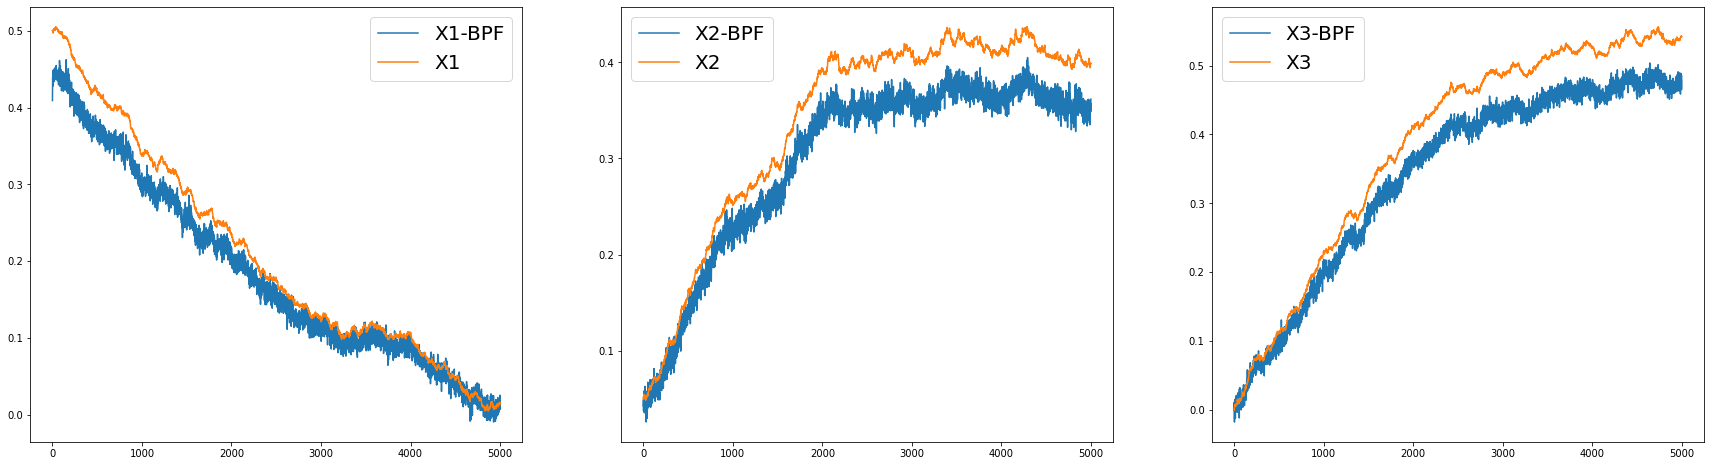

In [139]:
pylab.subplot (1, 3, 1)
plt.plot(bpf_out_1.mean_filtering, label='X1-BPF')
plt.plot(X[0,:],label='X1');
plt.legend(fontsize=20)

pylab.subplot (1, 3, 2)
plt.plot(bpf_out_2.mean_filtering, label='X2-BPF')
plt.plot(X[1,:],label='X2');
plt.legend(fontsize=20)

pylab.subplot (1, 3, 3)
plt.plot(bpf_out_3.mean_filtering, label='X3-BPF')
plt.plot(X[2,:],label='X3');
plt.legend(fontsize=20)

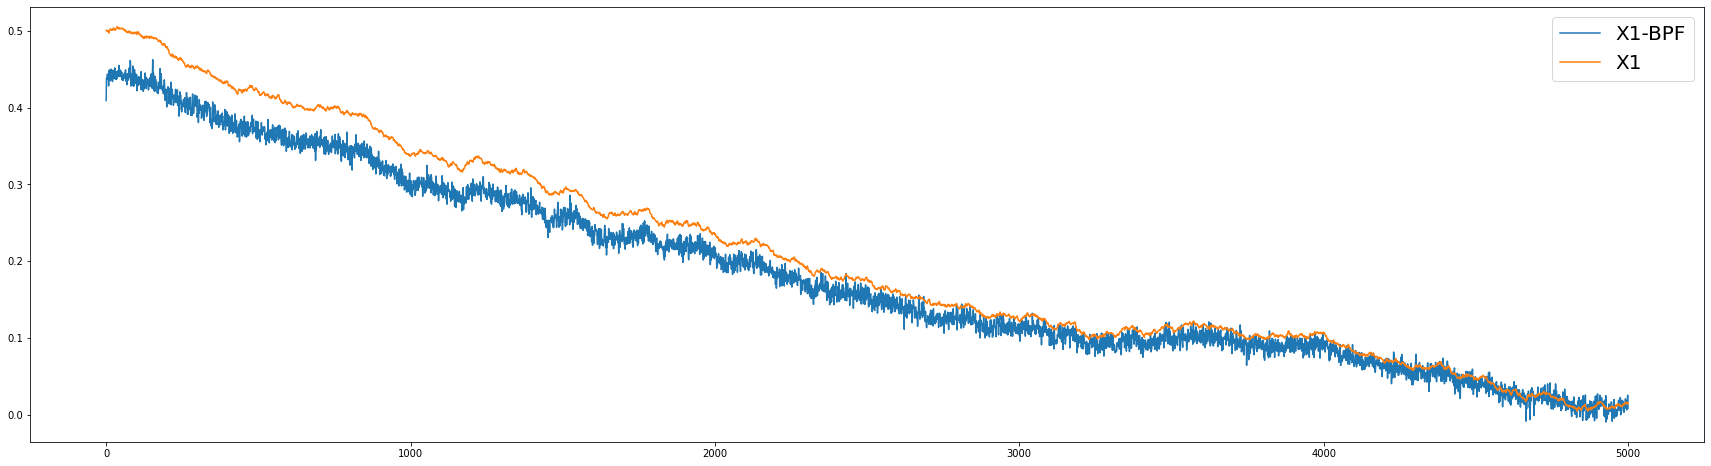

In [140]:
plt.plot(bpf_out_1.mean_filtering, label='X1-BPF')
plt.plot(X[0,:],label='X1');
plt.legend(fontsize=20)

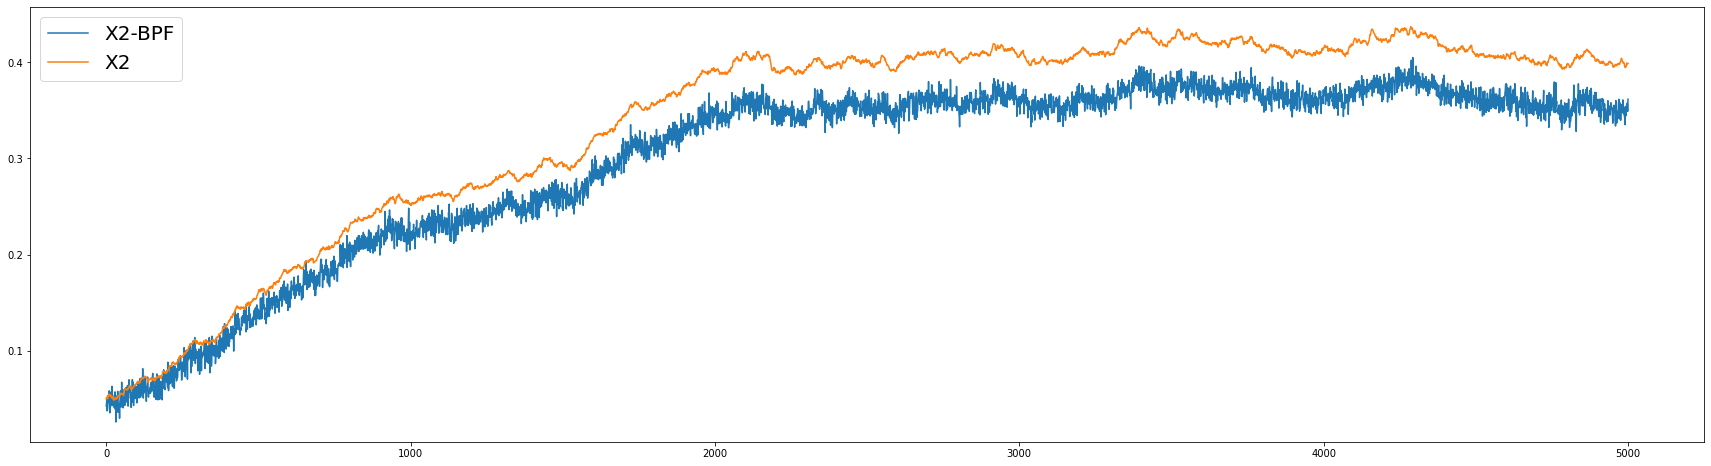

In [141]:
plt.plot(bpf_out_2.mean_filtering, label='X2-BPF')
plt.plot(X[1,:],label='X2');
plt.legend(fontsize=20)

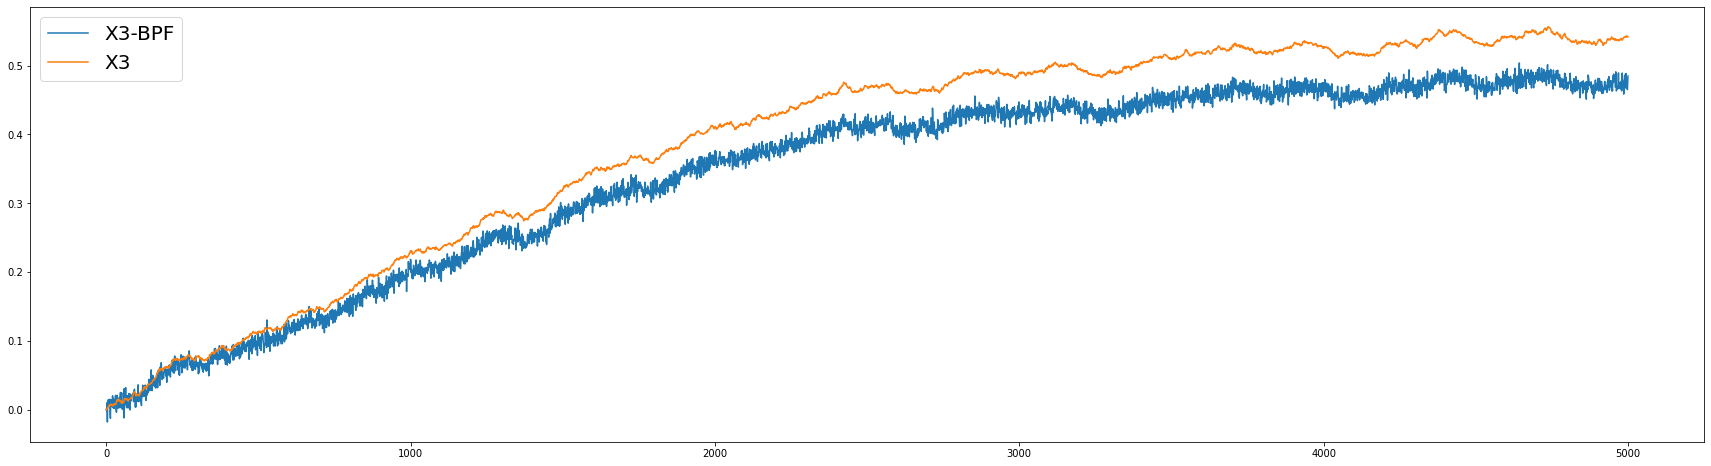

In [142]:
plt.plot(bpf_out_3.mean_filtering, label='X3-BPF')
plt.plot(X[2,:],label='X3');
plt.legend(fontsize=20)

In [143]:
BPF_avg = []
M = 1000
P0 = 0.05 
initial_mas = np.array([1.2,1.15,0.5,0.05])
initial_x = 0 
initial_Pt_filtering_tmp = P0
initial_particles_tmp = initial_particle_dist.rvs(M)
print(f"Running with {M} particles")
print(f"Running with {N_avg} trajectories")
for _ in tqdm(range(N_avg)):
    initial_particle_dist_tmp = scipy.stats.norm(0, np.sqrt(P0))
    BPF_tmp = []
    bpf_out_1_tmp = bootstrap_pf(initial_particles_tmp, X_avg[_,0,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])
    bpf_out_2_tmp = bootstrap_pf(initial_particles_tmp, X_avg[_,1,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])
    bpf_out_3_tmp = bootstrap_pf(initial_particles_tmp, X_avg[_,2,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])
    bpf_1_tmp = bpf_out_1_tmp.mean_filtering
    bpf_2_tmp = bpf_out_2_tmp.mean_filtering
    bpf_3_tmp = bpf_out_3_tmp.mean_filtering
    bpf_1_tmp = np.array(bpf_1_tmp)
    bpf_2_tmp = np.array(bpf_2_tmp)
    bpf_3_tmp = np.array(bpf_3_tmp)
    BPF_tmp.append(bpf_1_tmp)
    BPF_tmp.append(bpf_2_tmp)
    BPF_tmp.append(bpf_3_tmp)
    BPF_avg.append(BPF_tmp)

Running with 1000 particles
Running with 5000 trajectories


100%|██████████| 5000/5000 [36:09:40<00:00, 26.04s/it]   


In [126]:
BPF_avg = []
M = 1000
P0 = 0.05 
initial_mas = np.array([1.2,1.15,0.5,0.05])
initial_x = 0 
initial_Pt_filtering_tmp = P0
initial_particles_tmp = initial_particle_dist.rvs(M)
print(f"Running with {M} particles")
print(f"Running with {N_avg} trajectories")
for _ in tqdm(range(N_avg)):
    initial_particle_dist_tmp = scipy.stats.norm(0, np.sqrt(P0))
    BPF_tmp = []
    bpf_out_1_tmp = bootstrap_pf(initial_particles_tmp, X_avg[_,0,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])
    bpf_out_2_tmp = bootstrap_pf(initial_particles_tmp, X_avg[_,1,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])
    bpf_out_3_tmp = bootstrap_pf(initial_particles_tmp, X_avg[_,2,:], initial_mas[0], initial_mas[1], initial_mas[2], initial_mas[3])
    bpf_1_tmp = bpf_out_1_tmp.mean_filtering
    bpf_2_tmp = bpf_out_2_tmp.mean_filtering
    bpf_3_tmp = bpf_out_3_tmp.mean_filtering
    bpf_1_tmp = np.array(bpf_1_tmp)
    bpf_2_tmp = np.array(bpf_2_tmp)
    bpf_3_tmp = np.array(bpf_3_tmp)
    BPF_tmp.append(bpf_1_tmp)
    BPF_tmp.append(bpf_2_tmp)
    BPF_tmp.append(bpf_3_tmp)
    BPF_avg.append(BPF_tmp)

Running with 1000 particles
Running with 10000 trajectories


In [144]:
BPF_avg = np.array(BPF_avg)

In [145]:
BPF_std = np.std(X_avg - BPF_avg, axis=0)

### ***СКО ошибки для BPF***
<a class="anchor" id="4_1"></a>

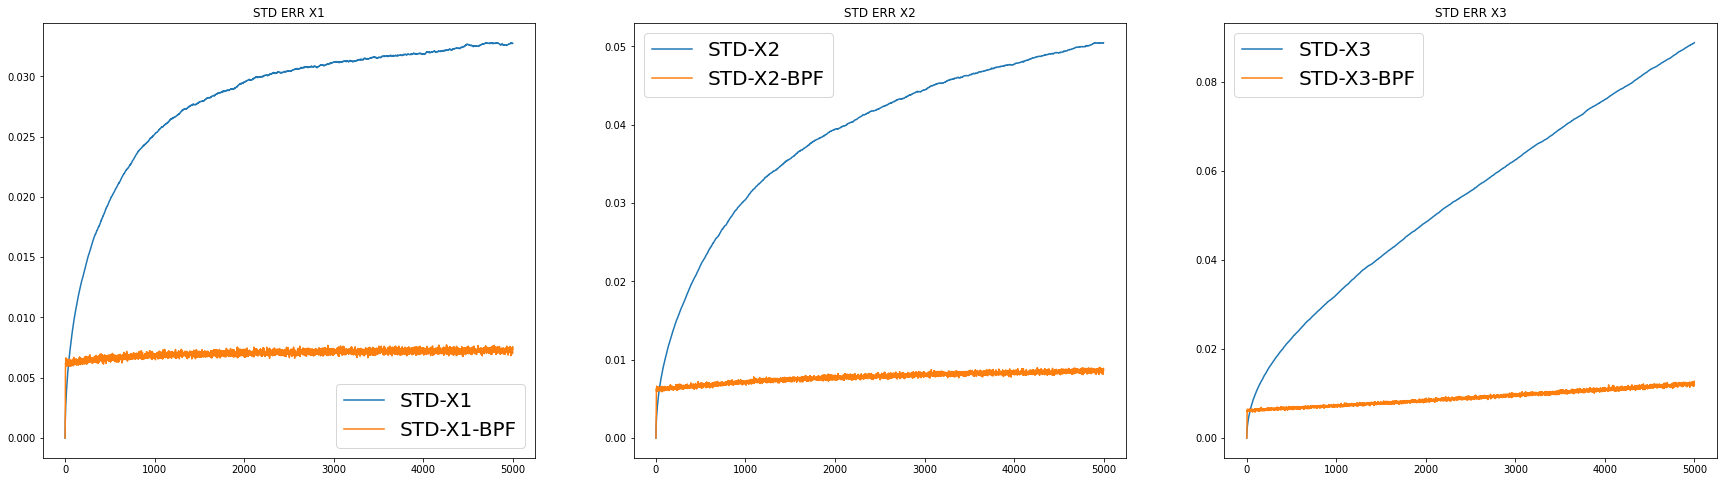

In [167]:
pylab.subplot (1, 3, 1)
plt.plot(std_x[0,:],label='STD-X1')
plt.plot(BPF_std[0,:],label='STD-X1-BPF')
plt.title('STD ERR X1')
plt.legend(fontsize=20)

pylab.subplot (1, 3, 2)
plt.plot(std_x[1,:],label='STD-X2')
plt.plot(BPF_std[1,:],label='STD-X2-BPF')
plt.title('STD ERR X2')
plt.legend(fontsize=20)

pylab.subplot (1, 3, 3)
plt.plot(std_x[2,:],label='STD-X3')
plt.plot(BPF_std[2,:],label='STD-X3-BPF')
plt.title('STD ERR X3')
plt.legend(fontsize=20)

0.021059095776961783


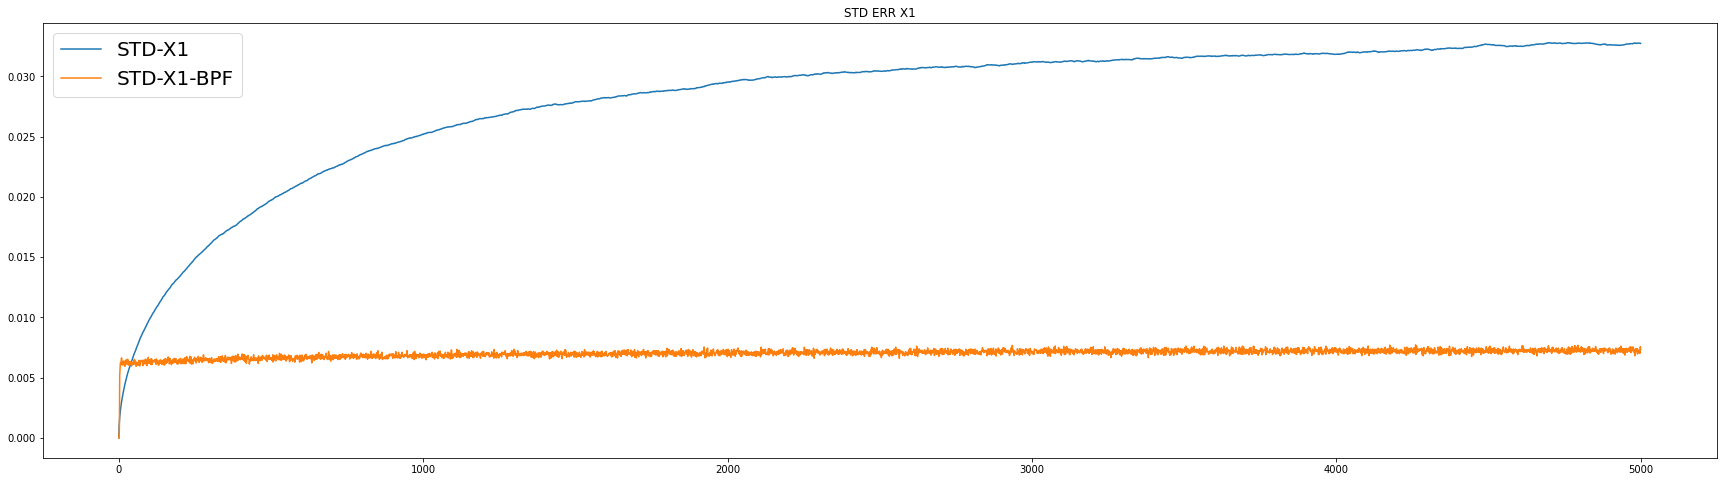

In [168]:
print(np.mean(std_x[0,:]-BPF_std[0,:]))
plt.plot(std_x[0,:],label='STD-X1')
plt.plot(BPF_std[0,:],label='STD-X1-BPF')
plt.title('STD ERR X1')
plt.legend(fontsize=20)

0.030994534522569298


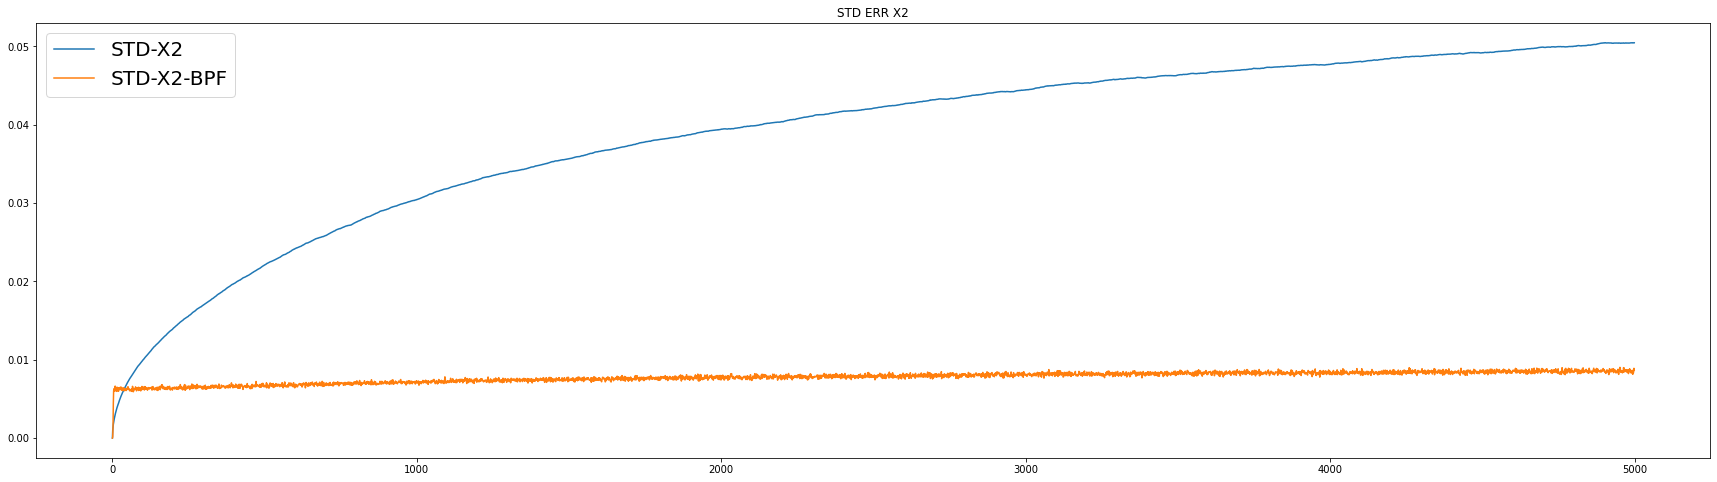

In [169]:
print(np.mean(std_x[1,:]-BPF_std[1,:]))
plt.plot(std_x[1,:],label='STD-X2')
plt.plot(BPF_std[1,:],label='STD-X2-BPF')
plt.title('STD ERR X2')
plt.legend(fontsize=20)

0.04478312317933553


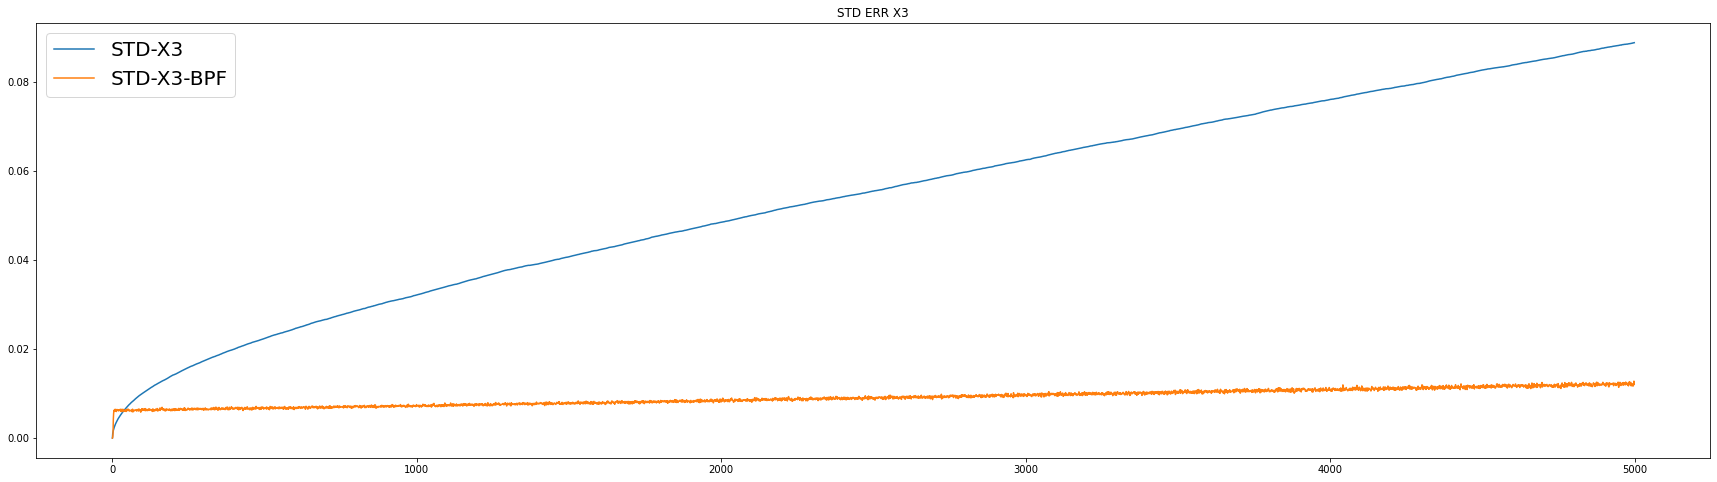

In [170]:
print(np.mean(std_x[2,:]-BPF_std[2,:]))
plt.plot(std_x[2,:],label='STD-X3')
plt.plot(BPF_std[2,:],label='STD-X3-BPF')
plt.title('STD ERR X3')
plt.legend(fontsize=20)

### ***Об оценке фильтрации***
<a class="anchor" id="4_2"></a>

Возьмем средние от СКО значения - СКО ошибки для BPF для каждой компоненты

$
\large mean(std_{i}(X)-std_{i}(BPF)), \space i = 0,1,2
$

In [171]:
print(np.mean(std_x[0,:]-BPF_std[0,:]))
print(np.mean(std_x[1,:]-BPF_std[1,:]))
print(np.mean(std_x[2,:]-BPF_std[2,:]))

0.021059095776961783
0.030994534522569298
0.04478312317933553


Для каждой траектории оценка BPF лучше тривиальной оценки, это и сразу очевидно из графиков

Оно и понятно, было взято по 1000 частиц для каждой компоненты на 1 траекторию

### ***Extensible Tensorflow library for differentiable particle filtering***
<a class="anchor" id="4_3"></a>

**Simple beautiful example [НАЖМИТЕ](https://github.com/JTT94/filterflow/blob/master/resonator.gif?raw=true)**

___________

# **Все на одном графике**
<a class="anchor" id="5"></a>

### ***Фильтры UKF и BPF на одном графике (задание 3)*** 
<a class="anchor" id="5_1"></a>

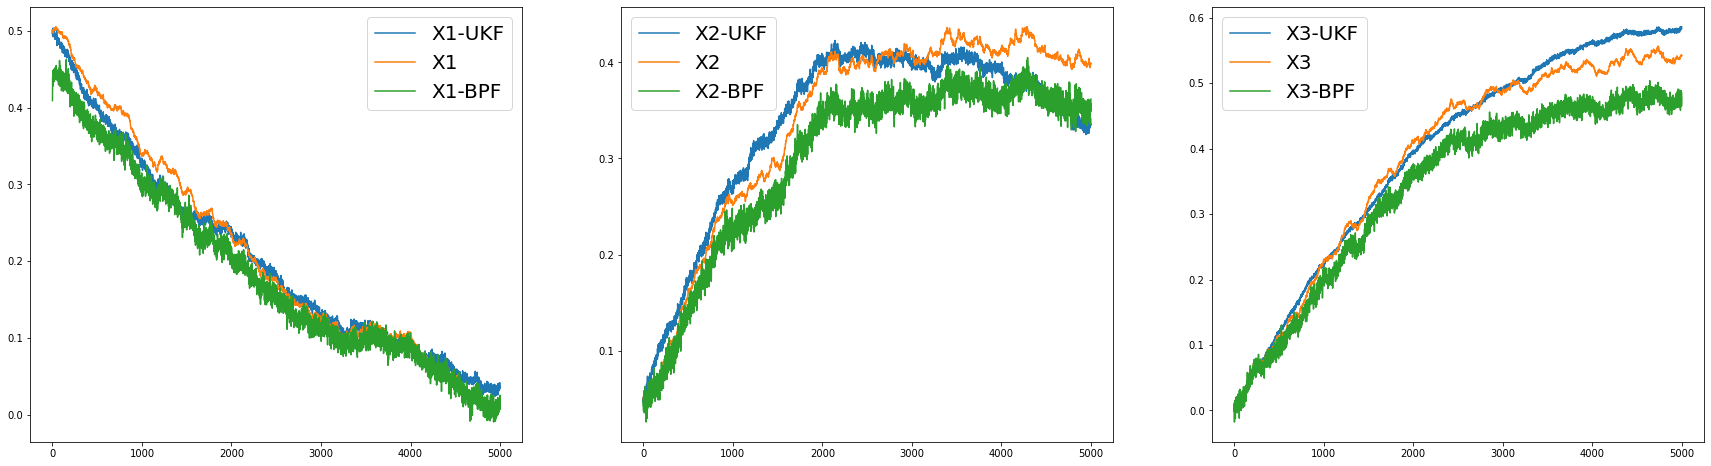

In [45]:
pylab.subplot (1, 3, 1)
plt.plot(xs1,label='X1-UKF');
plt.plot(X[0,:],label='X1');
plt.plot(bpf_out_1.mean_filtering, label='X1-BPF')
plt.legend(fontsize=20)

pylab.subplot (1, 3, 2)
plt.plot(xs2,label='X2-UKF');
plt.plot(X[1,:],label='X2');
plt.plot(bpf_out_2.mean_filtering, label='X2-BPF')
plt.legend(fontsize=20)

pylab.subplot (1, 3, 3)
plt.plot(xs3,label='X3-UKF');
plt.plot(X[2,:],label='X3');
plt.plot(bpf_out_3.mean_filtering, label='X3-BPF')
plt.legend(fontsize=20)

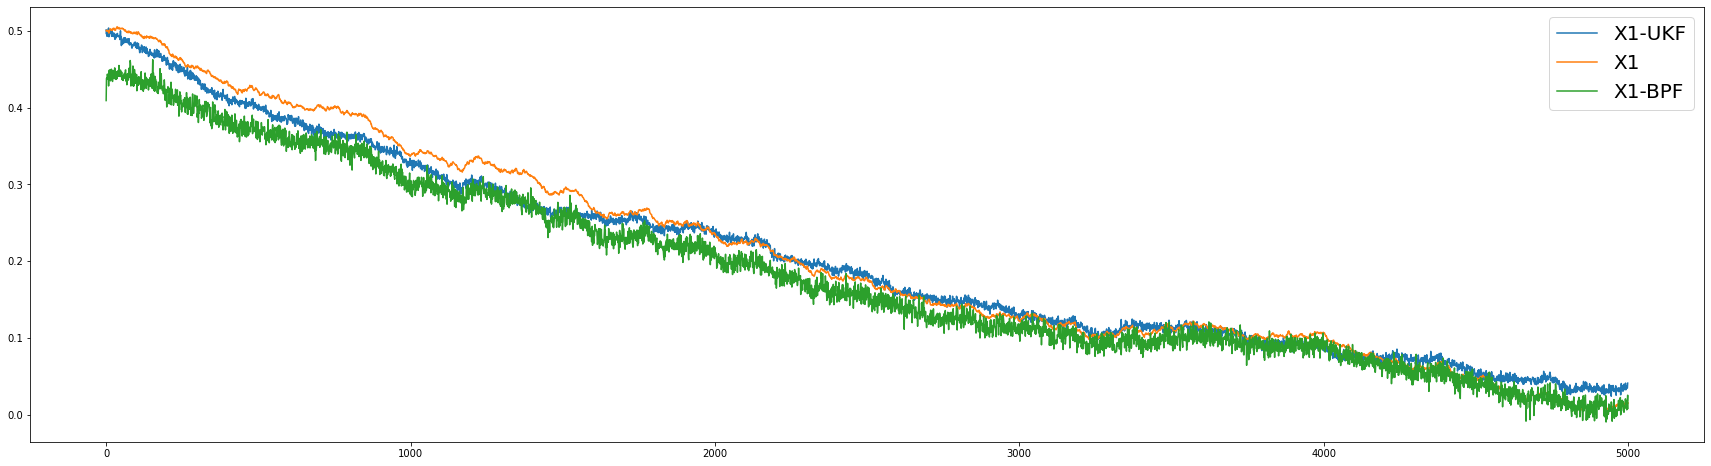

In [46]:
plt.plot(xs1,label='X1-UKF');
plt.plot(X[0,:],label='X1');
plt.plot(bpf_out_1.mean_filtering, label='X1-BPF')
plt.legend(fontsize=20)

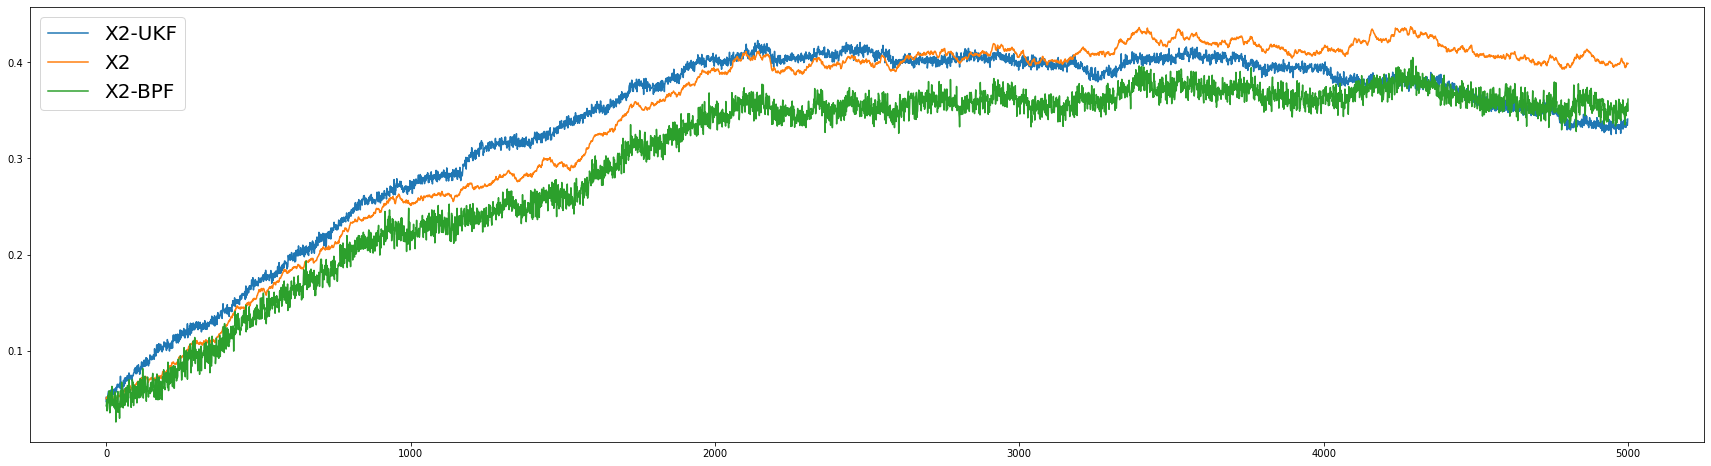

In [47]:
plt.plot(xs2,label='X2-UKF');
plt.plot(X[1,:],label='X2');
plt.plot(bpf_out_2.mean_filtering, label='X2-BPF')
plt.legend(fontsize=20)

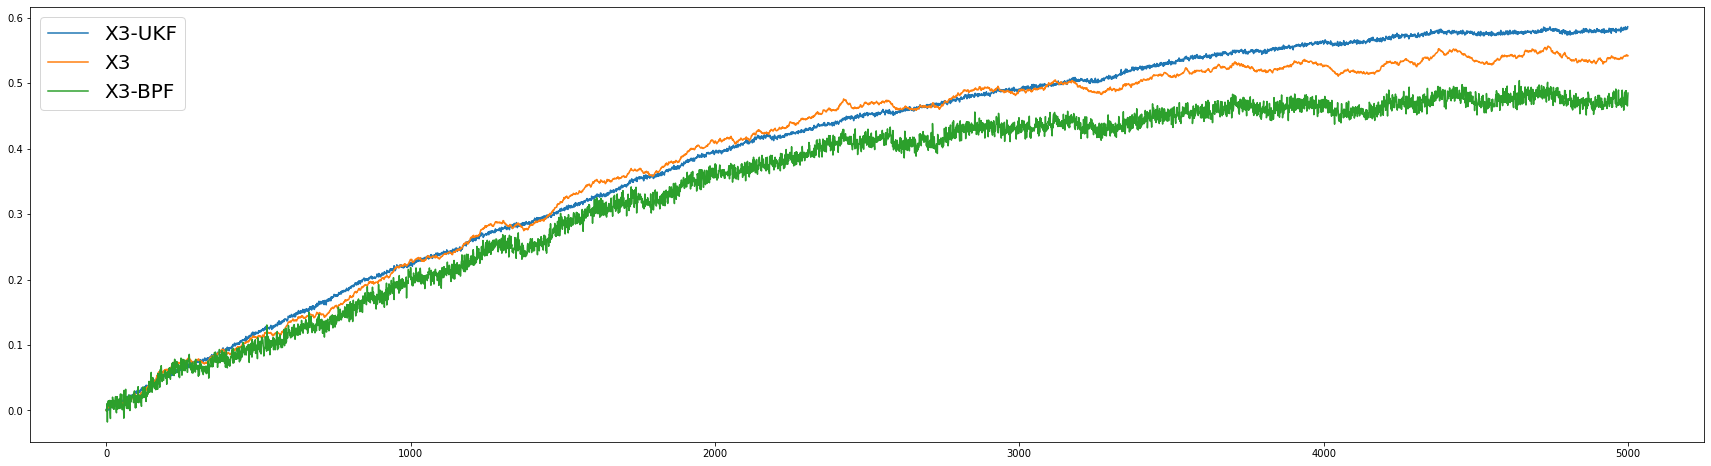

In [48]:
plt.plot(xs3,label='X3-UKF');
plt.plot(X[2,:],label='X3');
plt.plot(bpf_out_3.mean_filtering, label='X3-BPF')
plt.legend(fontsize=20)

### ***СКО значения и СКО ошибок UKF и BPF на одном графике для пучка траекторий (задание 4)*** 
<a class="anchor" id="5_2"></a>

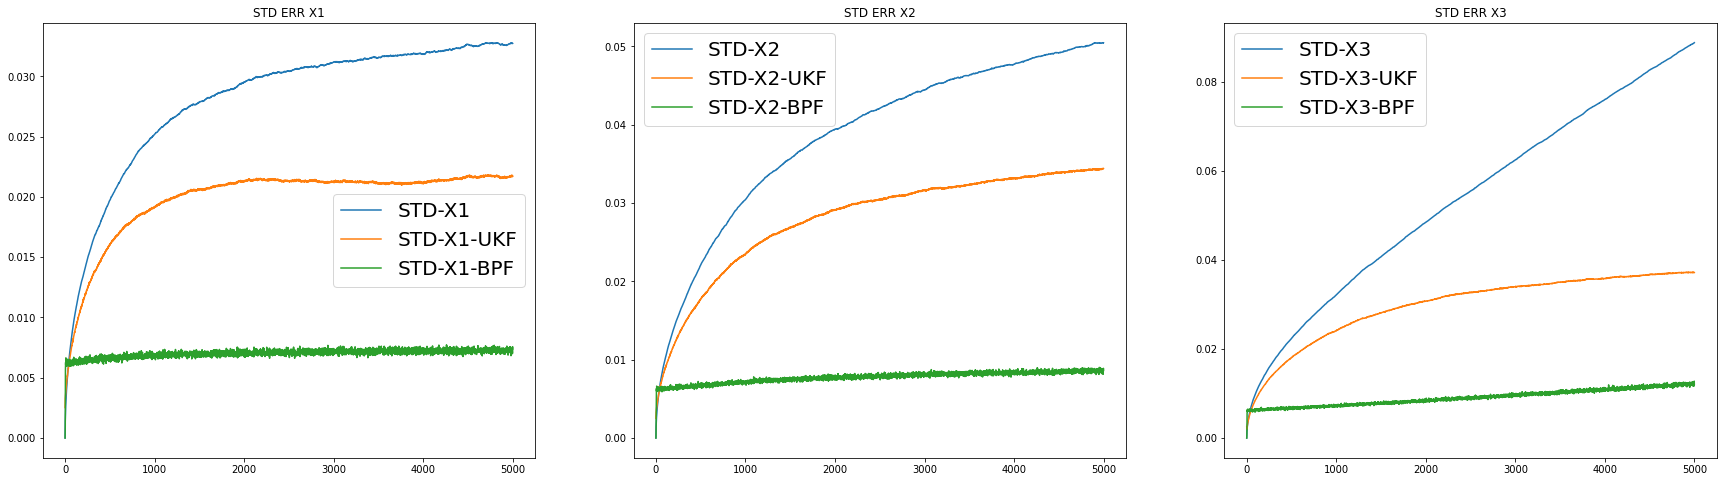

In [172]:
pylab.subplot (1, 3, 1)
plt.plot(std_x[0,:], label='STD-X1')
plt.plot(UKF_std[0,:],label='STD-X1-UKF')
plt.plot(BPF_std[0,:],label='STD-X1-BPF')
plt.title('STD ERR X1')
plt.legend(fontsize=20)

pylab.subplot (1, 3, 2)
plt.plot(std_x[1,:], label='STD-X2')
plt.plot(UKF_std[1,:], label='STD-X2-UKF')
plt.plot(BPF_std[1,:], label='STD-X2-BPF')
plt.title('STD ERR X2')
plt.legend(fontsize=20)

pylab.subplot (1, 3, 3)
plt.plot(std_x[2,:], label='STD-X3')
plt.plot(UKF_std[2,:], label='STD-X3-UKF')
plt.plot(BPF_std[2,:], label='STD-X3-BPF')
plt.title('STD ERR X3')
plt.legend(fontsize=20)

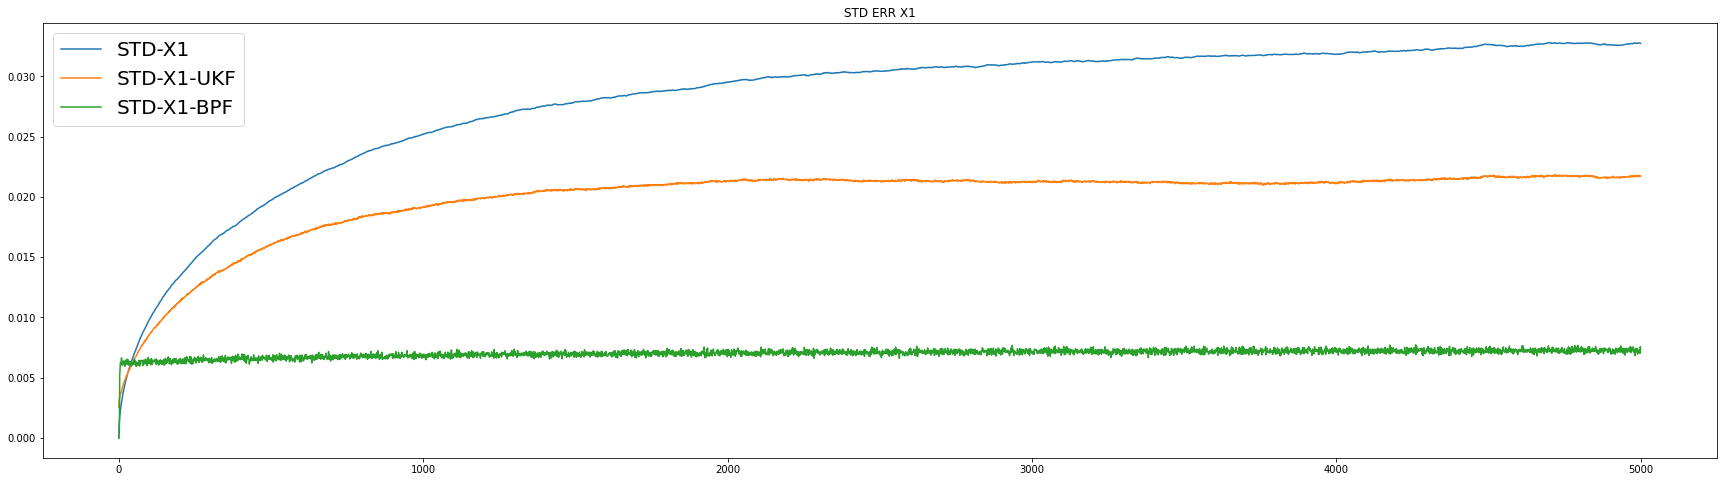

In [173]:
plt.plot(std_x[0,:], label='STD-X1')
plt.plot(UKF_std[0,:],label='STD-X1-UKF')
plt.plot(BPF_std[0,:],label='STD-X1-BPF')
plt.title('STD ERR X1')
plt.legend(fontsize=20)

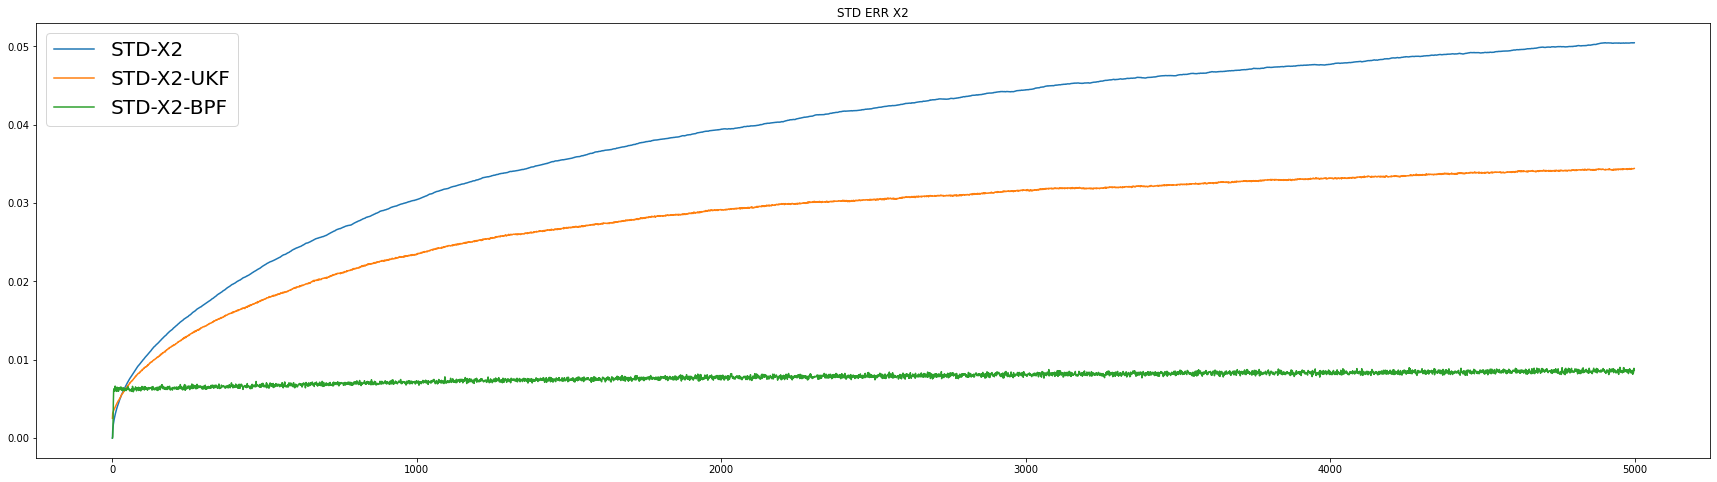

In [174]:
plt.plot(std_x[1,:], label='STD-X2')
plt.plot(UKF_std[1,:], label='STD-X2-UKF')
plt.plot(BPF_std[1,:], label='STD-X2-BPF')
plt.title('STD ERR X2')
plt.legend(fontsize=20)

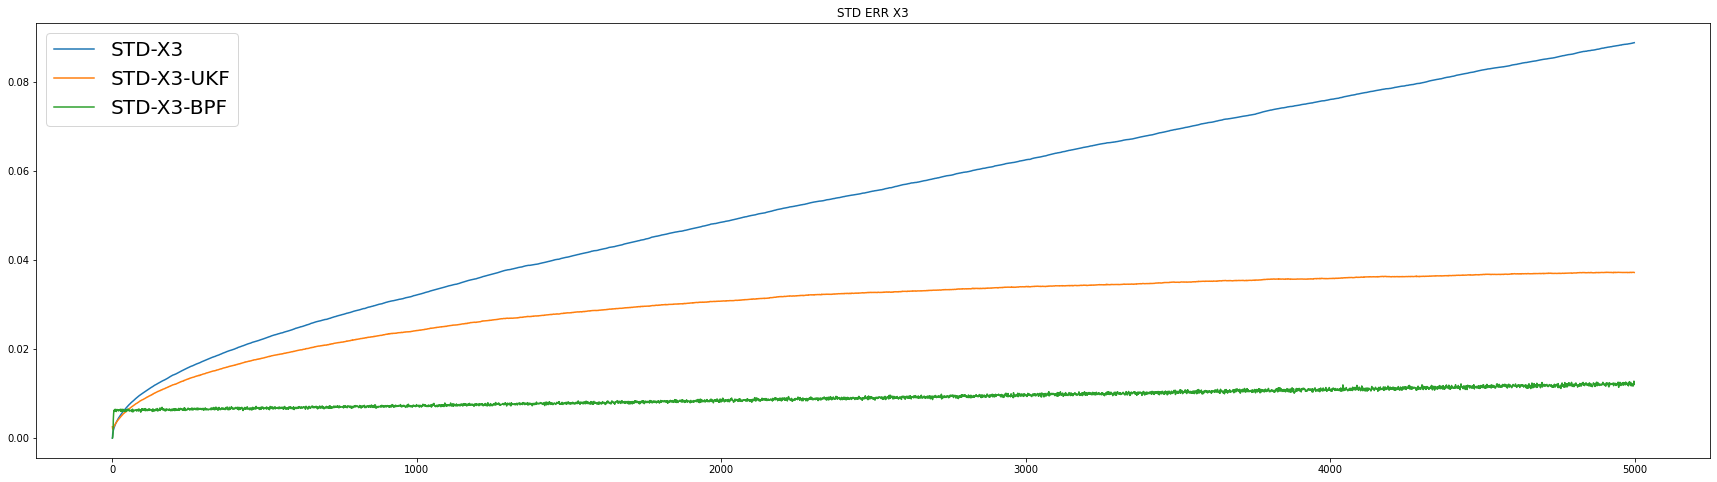

In [175]:
plt.plot(std_x[2,:], label='STD-X3')
plt.plot(UKF_std[2,:], label='STD-X3-UKF')
plt.plot(BPF_std[2,:], label='STD-X3-BPF')
plt.title('STD ERR X3')
plt.legend(fontsize=20)

_________

## **Список литературы**
<a class="anchor" id="6"></a>

- *[А.В. Борисов // Дополнительные главы теории случайных процессов. Лекция 10 - Метод частиц](https://vk.com/doc-195159079_622184080?hash=0cdc6934c3ba808404&dl=55a58c8b33d1507157)*
- *[А.В. Борисов // Дополнительные главы теории случайных процессов. Лекция 9 - Сигма-точечный алгоритм фильтрации и его модицификации](https://vk.com/doc148888053_620779679?hash=1d58e9c95ea28ed6e0&dl=be01d9ff12bfa42e47)*
- *[А.В. Борисов // Дополнительные главы теории случайных процессов. Лекция 3 - Формула Ито. Стохастические дифференциальные уравнения](https://vk.com/doc-195159079_615226506?hash=261811fc2beef150d6&dl=3a441b8c0a9079db4a)*
- *[The Unscented Kalman Filter GitHub by @rlabbe](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/10-Unscented-Kalman-Filter.ipynb)*
- *[Particle Filters GitHub by @rlabbe](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb)*
- *[Using a Particle Filter for Feedback Control GitHub by @UnofficialJuliaMirrorBot](https://github.com/UnofficialJuliaMirrorSnapshots/ParticleFilters.jl-c8b314e2-9260-5cf8-ae76-3be7461ca6d0/blob/8a15abc43f144bc45e31479d53430eaaf99f6477/notebooks/Using-a-Particle-Filter-for-Feedback-Control.ipynb)*
- *[Problems of Kalman and Particle Filtering GitHub by @JakobHavtorn](https://github.com/JakobHavtorn/seq-mc/blob/2f9d1afbf5b32aac15654eda0b48b3adcb63c86c/handin.ipynb)*
- *[Extensible Tensorflow library for differentiable particle filtering by @JTT94](https://github.com/JTT94/filterflow)*